## Exoplanet Model Work



#### Import packages

In [31]:
import pydot
import numpy as np
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import io
from keras.utils import plot_model
import random
import yaml
#import ktrain
from astropy.io import ascii as ap_ascii
import seaborn as sns
import os
import IPython

import matplotlib as mpl
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import kerastuner as kt

pd.set_option('display.float_format', lambda x: '%.5f' % x)
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.set_printoptions(precision=None, suppress=True)

from helpers.visualize import chart_curves 
from definitions import PROCESSED_DATA_DIR,PROCESSED_DATA_CATALOG
#PROCESSED_DATA_DIR='processed_data'
TCE_LIST='tce_table.csv'
FAILED_LIST='failed_kepids.csv'
MODEL_DIR='models'

BATCH_SIZE=96
METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')
    ]

#### Model analysis plotting and charting functions

In [3]:
def plot_metrics(history):
    metrics =  ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

        plt.legend()
    plt.show()


#roc curve
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    

#confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print('Not Planets Properly Categorized (True Negatives): ', cm[0][0])
    print('Not Planets Categorized as Planets Detected (False Positives): ', cm[0][1])
    print('Planets Missed (False Negatives): ', cm[1][0])
    print('Planets Properly Categorized (True Positives): ', cm[1][1])
    print('Total Planets: ', np.sum(cm[1]))
    print('Accuracy: ',(cm[0][0]+cm[1][1])/len(predictions))
    
#takes in the tce index number, the tce id table, the results table (which figures out tp etc),
#and the two vector tables and then calls the visualization helper function which
#creates a chart and saves inside of processed_data folder structure
def chart(tce_number,tce_id,results,x_global,x_local):
    kepid=tce_id.loc[tce_number].kepid
    result=val_results.loc[tce_number].result
    tce_plnt_num=tce_id.loc[tce_number].tce_plnt_num
    chart_curves(str(kepid),tce_plnt_num,
             result,
             x_global_val[tce_number],x_local_val[tce_number])
    

#### Read in and process data for use in model

(34032, 86)
(438, 2)
(33594, 86)
FALSE POSITIVE    29397
CONFIRMED          2345
CANDIDATE          1852
Name: koi_disposition, dtype: int64
0-FALSE POSITIVE    29397
1-CONFIRMED          4197
Name: koi_disposition, dtype: int64
Baseline accuracy: 0.8750669762457581
(33594, 201)
(33594, 2001)
(33594, 201)
(33594, 2001)


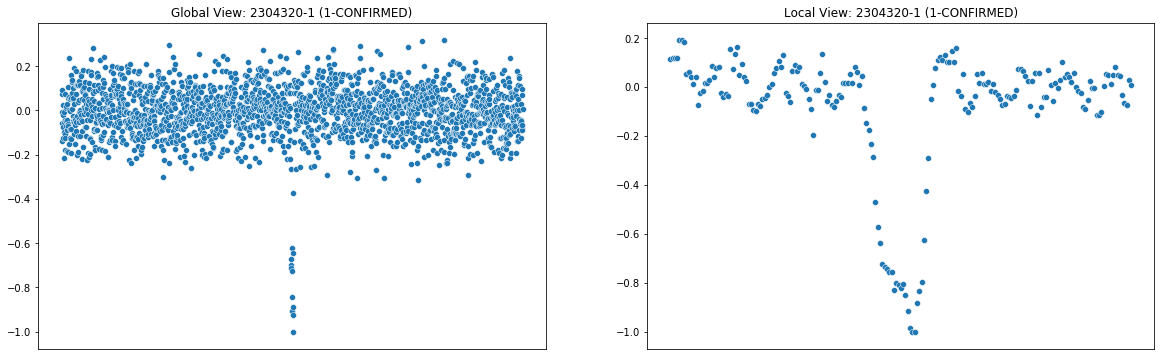

(33594, 201, 1)
(33594, 2001, 1)
(26875, 201, 1)
(26875, 2001, 1)
(26875,)
(26875, 3)
(6719, 201, 1)
(6719, 2001, 1)
(6719,)
(6719, 3)


In [4]:
def get_data():
    #this excludes from tce_list those kepids and planet numbers that failed make_data process
    processed=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,TCE_LIST))
    print(processed.shape)
    try:
        failed=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,FAILED_LIST))
        failed.columns=['kepid','tce_plnt_num']
        print(failed.shape)
        for index,row in failed.iterrows():
            processed.drop(processed[(processed.kepid==row.kepid) & 
                                     (processed.tce_plnt_num==row.tce_plnt_num)].index,inplace=True)
    except:
        pass

    processed=processed.reset_index(drop=True)
    print(processed.shape)

    #maybe need to save processed with failed KEPIDs in it and with a flag - do analysis of how many of those
    #are confirmed?

    #save processed list back out (so excludes those KEPIDS/PLNTs with NO light curves)
    processed.to_csv(os.path.join(PROCESSED_DATA_DIR,PROCESSED_DATA_CATALOG),index=False)
    
    
    print(processed.koi_disposition.value_counts())

    #combine confirmed and candidate
    #using 0 and 1 in front of name to force positive class to be planets
    processed.replace({'koi_disposition':
                       {'CANDIDATE':'1-CONFIRMED','CONFIRMED':'1-CONFIRMED','FALSE POSITIVE':'0-FALSE POSITIVE'}},
                      inplace=True)

    print(processed.koi_disposition.value_counts())
    print('Baseline accuracy:', processed[processed.koi_disposition=='0-FALSE POSITIVE'].shape[0]/processed.shape[0])

    
    LOCAL='localbinned_df.csv'
    GLOBAL='globalbinned_df.csv'
    x_local=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,LOCAL))
    x_global=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,GLOBAL))
    print(x_local.shape)
    print(x_global.shape)
    
    
    #add kepid and tce_plnt_number to x
    tce_id=pd.DataFrame()
    tce_id['kepid']=processed.kepid.astype('int')
    tce_id['tce_plnt_num']=processed.tce_plnt_num.astype('int')
    tce_id['koi_disposition']=processed.koi_disposition
    
    #turn into numpy arrays/series
    x_local=x_local.to_numpy()
    x_global=x_global.to_numpy()
    print(x_local.shape)
    print(x_global.shape)
    
    #can print out charts
    tce_number=3
    chart_curves(tce_id.kepid[tce_number],
                 tce_id.tce_plnt_num[tce_number],
                 x_global[tce_number],
                 x_local[tce_number],
                 tce_id.koi_disposition[tce_number])
    #Conv1D layers take in tensors of dimension (length of vector = 201 or 2001, and dimensions of vector=1)
    #So as with Conv2D in BW where need to add a color dimension here have to specify that there is only one
    #dimension in each vector
    x_local=np.expand_dims(x_local,axis=2)
    x_global=np.expand_dims(x_global,axis=2)

    print(x_local.shape)
    print(x_global.shape)
    
    #turn output into categorical variable with encoding
    Y=processed.koi_disposition
    le=LabelEncoder()
    le.fit(['1-CONFIRMED','0-FALSE POSITIVE'])
    Y=le.transform(Y)
    
    x_local_train, x_local_val, x_global_train, x_global_val, Y_train, Y_val,tce_id_train,tce_id_val = train_test_split(
    x_local,x_global, Y,tce_id, test_size=0.2)


    return (x_local_train, x_local_val, x_global_train, x_global_val, Y_train, Y_val,tce_id_train,tce_id_val)


x_local_train, x_local_val, x_global_train, x_global_val, Y_train, Y_val,tce_id_train,tce_id_val=get_data()   
print(x_local_train.shape)
print(x_global_train.shape)
print(Y_train.shape)
print(tce_id_train.shape)
print(x_local_val.shape)
print(x_global_val.shape)
print(Y_val.shape)
print(tce_id_val.shape)
    
    

In [46]:
#revised for keras-tuner
#model making that allows keras-tuner hyperparameter optimization to be run

def make_cnn_model(hp):
    #model = Sequential()   
    
    
    input_local = tf.keras.layers.Input(shape=[x_local_train.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global_train.shape[1],1])
    
    first_global_cnn_filters=hp.Int('first_global_cnn_filters',min_value=8,max_value=32,step=8)
    further_global_cnn_filters=hp.Int('further_global_cnn_filters',min_value=16,max_value=128, step=16)
    #can not have kernel greater than maxpool size?
    cnn_global_kernel=hp.Int('cnn_global_kernel',min_value=3,max_value=5,step=2)
    cnn_global_maxpool=hp.Int('cnn_global_maxpool',min_value=3,max_value=7,step=2)
    cnn_global_stride=hp.Int('cnn_global_stride',min_value=1,max_value=3,step=1)
    
    first_local_cnn_filters=hp.Int('first_local_cnn_filters',min_value=8,max_value=32,step=8)
    further_local_cnn_filters=hp.Int('further_local_cnn_filters',min_value=16,max_value=128, step=16)
    cnn_local_kernel=hp.Int('cnn_local_kernel',min_value=3,max_value=5,step=2)
    cnn_local_maxpool=hp.Int('cnn_local_maxpool',min_value=3,max_value=7,step=2)
    cnn_local_stride=hp.Int('cnn_local_stride',min_value=1,max_value=3,step=1)   
    
    cnn_activation=hp.Choice('cnn_activation',values=['relu'])#,'PReLU()'])
    
    
    #first global cnn
    k_global=tf.keras.layers.Conv1D(filters=first_global_cnn_filters,
                                    kernel_size=cnn_global_kernel,
                                    activation=cnn_activation)(input_global)
    
    k_global=tf.keras.layers.MaxPooling1D(pool_size=cnn_global_maxpool,
                                              strides=cnn_global_stride,padding='same')(k_global)
    
    #first local cnn
    k_local=tf.keras.layers.Conv1D(filters=first_local_cnn_filters,
                                    kernel_size=cnn_local_kernel,
                                    activation=cnn_activation)(input_local)
    
    k_local=tf.keras.layers.MaxPooling1D(pool_size=cnn_local_maxpool,
                                              strides=cnn_local_stride,padding='same')(k_local)
    
    
    
    further_global_cnn_layers=hp.Int('further_global_cnn_layers',min_value=1,max_value=3,step=1)
    further_local_cnn_layers=hp.Int('further_global_cnn_layers',min_value=1,max_value=3,step=1)
    
    for i in range(further_global_cnn_layers):
        k_global=tf.keras.layers.Conv1D(filters=further_global_cnn_filters,
                                    kernel_size=cnn_global_kernel,
                                    activation=cnn_activation)(k_global)
        k_global=tf.keras.layers.MaxPooling1D(pool_size=cnn_global_maxpool,
                                              strides=cnn_global_stride,padding='same')(k_global)
    
    for i in range(further_local_cnn_layers):
        k_local=tf.keras.layers.Conv1D(filters=further_local_cnn_filters,
                                    kernel_size=cnn_local_kernel,
                                    activation=cnn_activation)(k_local)
        k_local=tf.keras.layers.MaxPooling1D(pool_size=cnn_local_maxpool,
                                              strides=cnn_local_stride,padding='same')(k_local)
        
    #flatten and concatenate
    k_global=tf.keras.layers.Flatten()(k_global)
    k_local=tf.keras.layers.Flatten()(k_local)
    k = tf.keras.layers.concatenate([k_local, k_global])
    
    
    number_of_dense_layers=hp.Int('number_of_dense_layers',min_value=2,max_value=5,step=1)
    size_of_dense_layers=hp.Int('size_of_dense_layers',min_value=64, max_value=512, step=64)
    dense_activation=hp.Choice('dense_activation',values=['relu'])#,'PReLU()'])
    dense_dropout=hp.Choice('dense_dropout',values=[0.0,.2,.5])
    
    #now add dense layers
    for i in range(number_of_dense_layers):
        k=tf.keras.layers.Dense(size_of_dense_layers,activation=dense_activation)(k)
        k=tf.keras.layers.Dropout(dense_dropout)(k)
    
    #output layer        
    output=tf.keras.layers.Dense(1,activation='sigmoid')(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    learning_rate=hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=METRICS)
    return model

In [54]:
#when change model structure, have to remove optimization directory to stop it from
#trying to continue on from old tuning session
OPTIMIZATION_DIRECTORY='w2p_optimization'
dirpath=os.path.join(OPTIMIZATION_DIRECTORY)
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)


class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

#tuner=kt.BayesianOptimization(
tuner=MyTuner(
    make_cnn_model,
    kt.Objective("val_accuracy",direction="max"),
    max_trials=100,
    executions_per_trial=1,
    project_name=OPTIMIZATION_DIRECTORY
    )


#class ClearTrainingOutput(tf.keras.callbacks.Callback):
#  def on_train_end(*args, **kwargs):
#    IPython.display.clear_output(wait = True)
    
#tf.keras.backend.clear_session()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

NUMBER_OF_EPOCHS=10

tuner.search([x_local_train,x_global_train],
             Y_train,
             epochs = NUMBER_OF_EPOCHS, 
             validation_data=([x_local_val,x_global_val],Y_val),
             callbacks = [early_stopping],
             verbose=2)





Epoch 1/10
840/840 - 26s - loss: 0.1910 - tp: 2699.0000 - fp: 712.0000 - tn: 28685.0000 - fn: 1498.0000 - accuracy: 0.9342 - precision: 0.7913 - recall: 0.6431 - auc: 0.9452 - val_loss: 0.1396 - val_tp: 709.0000 - val_fp: 215.0000 - val_tn: 5679.0000 - val_fn: 116.0000 - val_accuracy: 0.9507 - val_precision: 0.7673 - val_recall: 0.8594 - val_auc: 0.9678
Epoch 2/10
840/840 - 27s - loss: 0.1308 - tp: 2686.0000 - fp: 541.0000 - tn: 22962.0000 - fn: 686.0000 - accuracy: 0.9543 - precision: 0.8324 - recall: 0.7966 - auc: 0.9672 - val_loss: 0.1240 - val_tp: 649.0000 - val_fp: 101.0000 - val_tn: 5793.0000 - val_fn: 176.0000 - val_accuracy: 0.9588 - val_precision: 0.8653 - val_recall: 0.7867 - val_auc: 0.9706
Epoch 3/10
840/840 - 27s - loss: 0.1058 - tp: 2823.0000 - fp: 375.0000 - tn: 23128.0000 - fn: 549.0000 - accuracy: 0.9656 - precision: 0.8827 - recall: 0.8372 - auc: 0.9759 - val_loss: 0.1217 - val_tp: 612.0000 - val_fp: 62.0000 - val_tn: 5832.0000 - val_fn: 213.0000 - val_accuracy: 0.959

Epoch 1/10
280/280 - 7s - loss: 0.2445 - tp: 1096.0000 - fp: 313.0000 - tn: 29084.0000 - fn: 3101.0000 - accuracy: 0.8984 - precision: 0.7779 - recall: 0.2611 - auc: 0.9147 - val_loss: 0.1779 - val_tp: 317.0000 - val_fp: 14.0000 - val_tn: 5880.0000 - val_fn: 508.0000 - val_accuracy: 0.9223 - val_precision: 0.9577 - val_recall: 0.3842 - val_auc: 0.9653
Epoch 2/10
280/280 - 6s - loss: 0.1672 - tp: 2180.0000 - fp: 268.0000 - tn: 23235.0000 - fn: 1192.0000 - accuracy: 0.9457 - precision: 0.8905 - recall: 0.6465 - auc: 0.9650 - val_loss: 0.1516 - val_tp: 664.0000 - val_fp: 113.0000 - val_tn: 5781.0000 - val_fn: 161.0000 - val_accuracy: 0.9592 - val_precision: 0.8546 - val_recall: 0.8048 - val_auc: 0.9667
Epoch 3/10
280/280 - 6s - loss: 0.1424 - tp: 2669.0000 - fp: 452.0000 - tn: 23051.0000 - fn: 703.0000 - accuracy: 0.9570 - precision: 0.8552 - recall: 0.7915 - auc: 0.9688 - val_loss: 0.1329 - val_tp: 719.0000 - val_fp: 161.0000 - val_tn: 5733.0000 - val_fn: 106.0000 - val_accuracy: 0.9603 

Epoch 1/10
168/168 - 9s - loss: 0.1844 - tp: 2926.0000 - fp: 856.0000 - tn: 28541.0000 - fn: 1271.0000 - accuracy: 0.9367 - precision: 0.7737 - recall: 0.6972 - auc: 0.9481 - val_loss: 0.1520 - val_tp: 519.0000 - val_fp: 65.0000 - val_tn: 5829.0000 - val_fn: 306.0000 - val_accuracy: 0.9448 - val_precision: 0.8887 - val_recall: 0.6291 - val_auc: 0.9623
Epoch 2/10
168/168 - 7s - loss: 0.1382 - tp: 2677.0000 - fp: 661.0000 - tn: 22842.0000 - fn: 695.0000 - accuracy: 0.9495 - precision: 0.8020 - recall: 0.7939 - auc: 0.9641 - val_loss: 0.1481 - val_tp: 712.0000 - val_fp: 252.0000 - val_tn: 5642.0000 - val_fn: 113.0000 - val_accuracy: 0.9457 - val_precision: 0.7386 - val_recall: 0.8630 - val_auc: 0.9673
Epoch 3/10
168/168 - 7s - loss: 0.1229 - tp: 2745.0000 - fp: 517.0000 - tn: 22986.0000 - fn: 627.0000 - accuracy: 0.9574 - precision: 0.8415 - recall: 0.8141 - auc: 0.9694 - val_loss: 0.1135 - val_tp: 719.0000 - val_fp: 137.0000 - val_tn: 5757.0000 - val_fn: 106.0000 - val_accuracy: 0.9638 -

Epoch 1/10
210/210 - 4s - loss: 0.2105 - tp: 2250.0000 - fp: 593.0000 - tn: 28804.0000 - fn: 1947.0000 - accuracy: 0.9244 - precision: 0.7914 - recall: 0.5361 - auc: 0.9408 - val_loss: 0.1617 - val_tp: 431.0000 - val_fp: 28.0000 - val_tn: 5866.0000 - val_fn: 394.0000 - val_accuracy: 0.9372 - val_precision: 0.9390 - val_recall: 0.5224 - val_auc: 0.9618
Epoch 2/10
210/210 - 3s - loss: 0.1579 - tp: 2442.0000 - fp: 503.0000 - tn: 23000.0000 - fn: 930.0000 - accuracy: 0.9467 - precision: 0.8292 - recall: 0.7242 - auc: 0.9582 - val_loss: 0.1580 - val_tp: 581.0000 - val_fp: 76.0000 - val_tn: 5818.0000 - val_fn: 244.0000 - val_accuracy: 0.9524 - val_precision: 0.8843 - val_recall: 0.7042 - val_auc: 0.9634
Epoch 3/10
210/210 - 3s - loss: 0.1492 - tp: 2439.0000 - fp: 422.0000 - tn: 23081.0000 - fn: 933.0000 - accuracy: 0.9496 - precision: 0.8525 - recall: 0.7233 - auc: 0.9618 - val_loss: 0.1483 - val_tp: 609.0000 - val_fp: 107.0000 - val_tn: 5787.0000 - val_fn: 216.0000 - val_accuracy: 0.9519 - 

Epoch 1/10
280/280 - 7s - loss: 0.7819 - tp: 2293.0000 - fp: 1070.0000 - tn: 28327.0000 - fn: 1904.0000 - accuracy: 0.9115 - precision: 0.6818 - recall: 0.5463 - auc: 0.9168 - val_loss: 0.2104 - val_tp: 446.0000 - val_fp: 177.0000 - val_tn: 5717.0000 - val_fn: 379.0000 - val_accuracy: 0.9172 - val_precision: 0.7159 - val_recall: 0.5406 - val_auc: 0.9329
Epoch 2/10
280/280 - 6s - loss: 0.2036 - tp: 2278.0000 - fp: 983.0000 - tn: 22520.0000 - fn: 1094.0000 - accuracy: 0.9227 - precision: 0.6986 - recall: 0.6756 - auc: 0.9323 - val_loss: 0.1882 - val_tp: 578.0000 - val_fp: 190.0000 - val_tn: 5704.0000 - val_fn: 247.0000 - val_accuracy: 0.9350 - val_precision: 0.7526 - val_recall: 0.7006 - val_auc: 0.9469
Epoch 3/10
280/280 - 6s - loss: 0.1921 - tp: 2322.0000 - fp: 937.0000 - tn: 22566.0000 - fn: 1050.0000 - accuracy: 0.9261 - precision: 0.7125 - recall: 0.6886 - auc: 0.9374 - val_loss: 0.1834 - val_tp: 622.0000 - val_fp: 224.0000 - val_tn: 5670.0000 - val_fn: 203.0000 - val_accuracy: 0.93

Epoch 1/10
120/120 - 7s - loss: 0.1981 - tp: 2270.0000 - fp: 702.0000 - tn: 28695.0000 - fn: 1927.0000 - accuracy: 0.9217 - precision: 0.7638 - recall: 0.5409 - auc: 0.9362 - val_loss: 0.1323 - val_tp: 644.0000 - val_fp: 129.0000 - val_tn: 5765.0000 - val_fn: 181.0000 - val_accuracy: 0.9539 - val_precision: 0.8331 - val_recall: 0.7806 - val_auc: 0.9660
Epoch 2/10
120/120 - 4s - loss: 0.1331 - tp: 2646.0000 - fp: 544.0000 - tn: 22959.0000 - fn: 726.0000 - accuracy: 0.9527 - precision: 0.8295 - recall: 0.7847 - auc: 0.9678 - val_loss: 0.1161 - val_tp: 680.0000 - val_fp: 119.0000 - val_tn: 5775.0000 - val_fn: 145.0000 - val_accuracy: 0.9607 - val_precision: 0.8511 - val_recall: 0.8242 - val_auc: 0.9715
Epoch 3/10
120/120 - 4s - loss: 0.1186 - tp: 2766.0000 - fp: 509.0000 - tn: 22994.0000 - fn: 606.0000 - accuracy: 0.9585 - precision: 0.8446 - recall: 0.8203 - auc: 0.9716 - val_loss: 0.1175 - val_tp: 718.0000 - val_fp: 149.0000 - val_tn: 5745.0000 - val_fn: 107.0000 - val_accuracy: 0.9619 

Epoch 1/10
420/420 - 7s - loss: 0.5244 - tp: 767.0000 - fp: 690.0000 - tn: 28707.0000 - fn: 3430.0000 - accuracy: 0.8774 - precision: 0.5264 - recall: 0.1827 - auc: 0.6750 - val_loss: 0.2383 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9461
Epoch 2/10
420/420 - 6s - loss: 0.2341 - tp: 0.0000e+00 - fp: 3.0000 - tn: 23500.0000 - fn: 3372.0000 - accuracy: 0.8744 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9277 - val_loss: 0.1972 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9548
Epoch 3/10
420/420 - 6s - loss: 0.2109 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23503.0000 - fn: 3372.0000 - accuracy: 0.8745 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9437 - val_loss: 0.1944 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.

Epoch 1/10
105/105 - 7s - loss: 0.2613 - tp: 664.0000 - fp: 456.0000 - tn: 28941.0000 - fn: 3533.0000 - accuracy: 0.8813 - precision: 0.5929 - recall: 0.1582 - auc: 0.8973 - val_loss: 0.1697 - val_tp: 475.0000 - val_fp: 90.0000 - val_tn: 5804.0000 - val_fn: 350.0000 - val_accuracy: 0.9345 - val_precision: 0.8407 - val_recall: 0.5758 - val_auc: 0.9565
Epoch 2/10
105/105 - 6s - loss: 0.1566 - tp: 2407.0000 - fp: 658.0000 - tn: 22845.0000 - fn: 965.0000 - accuracy: 0.9396 - precision: 0.7853 - recall: 0.7138 - auc: 0.9599 - val_loss: 0.1442 - val_tp: 593.0000 - val_fp: 117.0000 - val_tn: 5777.0000 - val_fn: 232.0000 - val_accuracy: 0.9481 - val_precision: 0.8352 - val_recall: 0.7188 - val_auc: 0.9622
Epoch 3/10
105/105 - 6s - loss: 0.1396 - tp: 2502.0000 - fp: 558.0000 - tn: 22945.0000 - fn: 870.0000 - accuracy: 0.9469 - precision: 0.8176 - recall: 0.7420 - auc: 0.9656 - val_loss: 0.1328 - val_tp: 610.0000 - val_fp: 91.0000 - val_tn: 5803.0000 - val_fn: 215.0000 - val_accuracy: 0.9545 - v

Epoch 1/10
840/840 - 12s - loss: 3.1894 - tp: 1685.0000 - fp: 725.0000 - tn: 28672.0000 - fn: 2512.0000 - accuracy: 0.9036 - precision: 0.6992 - recall: 0.4015 - auc: 0.9165 - val_loss: 0.2581 - val_tp: 0.0000e+00 - val_fp: 3.0000 - val_tn: 5891.0000 - val_fn: 825.0000 - val_accuracy: 0.8768 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9049
Epoch 2/10
840/840 - 12s - loss: 0.2369 - tp: 1314.0000 - fp: 603.0000 - tn: 22900.0000 - fn: 2058.0000 - accuracy: 0.9010 - precision: 0.6854 - recall: 0.3897 - auc: 0.9118 - val_loss: 0.1857 - val_tp: 507.0000 - val_fp: 181.0000 - val_tn: 5713.0000 - val_fn: 318.0000 - val_accuracy: 0.9257 - val_precision: 0.7369 - val_recall: 0.6145 - val_auc: 0.9461
Epoch 3/10
840/840 - 12s - loss: 0.1909 - tp: 1878.0000 - fp: 552.0000 - tn: 22951.0000 - fn: 1494.0000 - accuracy: 0.9239 - precision: 0.7728 - recall: 0.5569 - auc: 0.9410 - val_loss: 0.1818 - val_tp: 471.0000 - val_fp: 116.0000 - val_tn: 5778.0000 - val_fn: 354.0000 - val_accu

Epoch 1/10
105/105 - 19s - loss: 0.2381 - tp: 1240.0000 - fp: 351.0000 - tn: 29046.0000 - fn: 2957.0000 - accuracy: 0.9015 - precision: 0.7794 - recall: 0.2954 - auc: 0.8600 - val_loss: 0.1595 - val_tp: 613.0000 - val_fp: 185.0000 - val_tn: 5709.0000 - val_fn: 212.0000 - val_accuracy: 0.9409 - val_precision: 0.7682 - val_recall: 0.7430 - val_auc: 0.9557
Epoch 2/10
105/105 - 23s - loss: 0.1508 - tp: 2516.0000 - fp: 669.0000 - tn: 22834.0000 - fn: 856.0000 - accuracy: 0.9433 - precision: 0.7900 - recall: 0.7461 - auc: 0.9610 - val_loss: 0.1488 - val_tp: 675.0000 - val_fp: 212.0000 - val_tn: 5682.0000 - val_fn: 150.0000 - val_accuracy: 0.9461 - val_precision: 0.7610 - val_recall: 0.8182 - val_auc: 0.9625
Epoch 3/10
105/105 - 23s - loss: 0.1307 - tp: 2677.0000 - fp: 605.0000 - tn: 22898.0000 - fn: 695.0000 - accuracy: 0.9516 - precision: 0.8157 - recall: 0.7939 - auc: 0.9691 - val_loss: 0.1425 - val_tp: 606.0000 - val_fp: 127.0000 - val_tn: 5767.0000 - val_fn: 219.0000 - val_accuracy: 0.94

Epoch 1/10
840/840 - 32s - loss: 0.3444 - tp: 692.0000 - fp: 280.0000 - tn: 29117.0000 - fn: 3505.0000 - accuracy: 0.8873 - precision: 0.7119 - recall: 0.1649 - auc: 0.8611 - val_loss: 0.3733 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5039
Epoch 2/10
840/840 - 30s - loss: 0.3506 - tp: 0.0000e+00 - fp: 11.0000 - tn: 23492.0000 - fn: 3372.0000 - accuracy: 0.8741 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7274 - val_loss: 0.3608 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5895
Epoch 3/10
840/840 - 30s - loss: 0.3975 - tp: 6.0000 - fp: 23.0000 - tn: 23480.0000 - fn: 3366.0000 - accuracy: 0.8739 - precision: 0.2069 - recall: 0.0018 - auc: 0.5797 - val_loss: 0.3727 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_

Epoch 1/10
105/105 - 4s - loss: 0.3357 - tp: 0.0000e+00 - fp: 2.0000 - tn: 29395.0000 - fn: 4197.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7382 - val_loss: 0.2223 - val_tp: 30.0000 - val_fp: 3.0000 - val_tn: 5891.0000 - val_fn: 795.0000 - val_accuracy: 0.8812 - val_precision: 0.9091 - val_recall: 0.0364 - val_auc: 0.9345
Epoch 2/10
105/105 - 3s - loss: 0.1750 - tp: 2116.0000 - fp: 619.0000 - tn: 22884.0000 - fn: 1256.0000 - accuracy: 0.9302 - precision: 0.7737 - recall: 0.6275 - auc: 0.9505 - val_loss: 0.1552 - val_tp: 557.0000 - val_fp: 134.0000 - val_tn: 5760.0000 - val_fn: 268.0000 - val_accuracy: 0.9402 - val_precision: 0.8061 - val_recall: 0.6752 - val_auc: 0.9576
Epoch 3/10
105/105 - 3s - loss: 0.1472 - tp: 2507.0000 - fp: 623.0000 - tn: 22880.0000 - fn: 865.0000 - accuracy: 0.9446 - precision: 0.8010 - recall: 0.7435 - auc: 0.9617 - val_loss: 0.1466 - val_tp: 676.0000 - val_fp: 196.0000 - val_tn: 5698.0000 - val_fn: 149.0000 - val_accuracy: 0.

Epoch 1/10
105/105 - 8s - loss: 0.3770 - tp: 896.0000 - fp: 322.0000 - tn: 29075.0000 - fn: 3301.0000 - accuracy: 0.8922 - precision: 0.7356 - recall: 0.2135 - auc: 0.8964 - val_loss: 0.1990 - val_tp: 569.0000 - val_fp: 284.0000 - val_tn: 5610.0000 - val_fn: 256.0000 - val_accuracy: 0.9196 - val_precision: 0.6671 - val_recall: 0.6897 - val_auc: 0.9395
Epoch 2/10
105/105 - 7s - loss: 0.1921 - tp: 2025.0000 - fp: 660.0000 - tn: 22843.0000 - fn: 1347.0000 - accuracy: 0.9253 - precision: 0.7542 - recall: 0.6005 - auc: 0.9399 - val_loss: 0.1755 - val_tp: 517.0000 - val_fp: 135.0000 - val_tn: 5759.0000 - val_fn: 308.0000 - val_accuracy: 0.9341 - val_precision: 0.7929 - val_recall: 0.6267 - val_auc: 0.9484
Epoch 3/10
105/105 - 7s - loss: 0.1871 - tp: 2134.0000 - fp: 668.0000 - tn: 22835.0000 - fn: 1238.0000 - accuracy: 0.9291 - precision: 0.7616 - recall: 0.6329 - auc: 0.9423 - val_loss: 0.1822 - val_tp: 631.0000 - val_fp: 299.0000 - val_tn: 5595.0000 - val_fn: 194.0000 - val_accuracy: 0.9266

Epoch 1/10
840/840 - 6s - loss: 0.1785 - tp: 2666.0000 - fp: 803.0000 - tn: 28594.0000 - fn: 1531.0000 - accuracy: 0.9305 - precision: 0.7685 - recall: 0.6352 - auc: 0.9491 - val_loss: 0.1426 - val_tp: 678.0000 - val_fp: 194.0000 - val_tn: 5700.0000 - val_fn: 147.0000 - val_accuracy: 0.9492 - val_precision: 0.7775 - val_recall: 0.8218 - val_auc: 0.9635
Epoch 2/10
840/840 - 5s - loss: 0.1345 - tp: 2591.0000 - fp: 553.0000 - tn: 22950.0000 - fn: 781.0000 - accuracy: 0.9504 - precision: 0.8241 - recall: 0.7684 - auc: 0.9672 - val_loss: 0.1320 - val_tp: 668.0000 - val_fp: 154.0000 - val_tn: 5740.0000 - val_fn: 157.0000 - val_accuracy: 0.9537 - val_precision: 0.8127 - val_recall: 0.8097 - val_auc: 0.9653
Epoch 3/10
840/840 - 5s - loss: 0.1258 - tp: 2654.0000 - fp: 511.0000 - tn: 22992.0000 - fn: 718.0000 - accuracy: 0.9543 - precision: 0.8385 - recall: 0.7871 - auc: 0.9700 - val_loss: 0.1276 - val_tp: 637.0000 - val_fp: 110.0000 - val_tn: 5784.0000 - val_fn: 188.0000 - val_accuracy: 0.9556 

Epoch 1/10
105/105 - 2s - loss: 0.3002 - tp: 695.0000 - fp: 314.0000 - tn: 29083.0000 - fn: 3502.0000 - accuracy: 0.8864 - precision: 0.6888 - recall: 0.1656 - auc: 0.8659 - val_loss: 0.2177 - val_tp: 93.0000 - val_fp: 22.0000 - val_tn: 5872.0000 - val_fn: 732.0000 - val_accuracy: 0.8878 - val_precision: 0.8087 - val_recall: 0.1127 - val_auc: 0.9362
Epoch 2/10
105/105 - 1s - loss: 0.1948 - tp: 1554.0000 - fp: 434.0000 - tn: 23069.0000 - fn: 1818.0000 - accuracy: 0.9162 - precision: 0.7817 - recall: 0.4609 - auc: 0.9465 - val_loss: 0.1653 - val_tp: 589.0000 - val_fp: 157.0000 - val_tn: 5737.0000 - val_fn: 236.0000 - val_accuracy: 0.9415 - val_precision: 0.7895 - val_recall: 0.7139 - val_auc: 0.9590
Epoch 3/10
105/105 - 1s - loss: 0.1599 - tp: 2407.0000 - fp: 622.0000 - tn: 22881.0000 - fn: 965.0000 - accuracy: 0.9409 - precision: 0.7947 - recall: 0.7138 - auc: 0.9596 - val_loss: 0.1481 - val_tp: 614.0000 - val_fp: 140.0000 - val_tn: 5754.0000 - val_fn: 211.0000 - val_accuracy: 0.9478 - 

Epoch 1/10
840/840 - 11s - loss: 0.2071 - tp: 2481.0000 - fp: 710.0000 - tn: 28687.0000 - fn: 1716.0000 - accuracy: 0.9278 - precision: 0.7775 - recall: 0.5911 - auc: 0.9371 - val_loss: 0.1640 - val_tp: 575.0000 - val_fp: 155.0000 - val_tn: 5739.0000 - val_fn: 250.0000 - val_accuracy: 0.9397 - val_precision: 0.7877 - val_recall: 0.6970 - val_auc: 0.9522
Epoch 2/10
840/840 - 10s - loss: 0.1527 - tp: 2583.0000 - fp: 715.0000 - tn: 22788.0000 - fn: 789.0000 - accuracy: 0.9440 - precision: 0.7832 - recall: 0.7660 - auc: 0.9581 - val_loss: 0.1488 - val_tp: 571.0000 - val_fp: 119.0000 - val_tn: 5775.0000 - val_fn: 254.0000 - val_accuracy: 0.9445 - val_precision: 0.8275 - val_recall: 0.6921 - val_auc: 0.9619
Epoch 3/10
840/840 - 10s - loss: 0.1342 - tp: 2692.0000 - fp: 629.0000 - tn: 22874.0000 - fn: 680.0000 - accuracy: 0.9513 - precision: 0.8106 - recall: 0.7983 - auc: 0.9661 - val_loss: 0.1347 - val_tp: 633.0000 - val_fp: 135.0000 - val_tn: 5759.0000 - val_fn: 192.0000 - val_accuracy: 0.95

Epoch 1/10
840/840 - 7s - loss: 0.3451 - tp: 865.0000 - fp: 374.0000 - tn: 29023.0000 - fn: 3332.0000 - accuracy: 0.8897 - precision: 0.6981 - recall: 0.2061 - auc: 0.8751 - val_loss: 0.2711 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9147
Epoch 2/10
840/840 - 6s - loss: 0.7635 - tp: 129.0000 - fp: 119.0000 - tn: 23384.0000 - fn: 3243.0000 - accuracy: 0.8749 - precision: 0.5202 - recall: 0.0383 - auc: 0.6780 - val_loss: 0.4116 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5260
Epoch 3/10
840/840 - 6s - loss: 0.3947 - tp: 0.0000e+00 - fp: 1.0000 - tn: 23502.0000 - fn: 3372.0000 - accuracy: 0.8745 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5034 - val_loss: 0.3736 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 5893.0000 - val_fn: 8

Epoch 1/10
105/105 - 6s - loss: 3.8928 - tp: 990.0000 - fp: 782.0000 - tn: 28615.0000 - fn: 3207.0000 - accuracy: 0.8813 - precision: 0.5587 - recall: 0.2359 - auc: 0.8465 - val_loss: 0.2006 - val_tp: 602.0000 - val_fp: 304.0000 - val_tn: 5590.0000 - val_fn: 223.0000 - val_accuracy: 0.9216 - val_precision: 0.6645 - val_recall: 0.7297 - val_auc: 0.9415
Epoch 2/10
105/105 - 6s - loss: 0.1889 - tp: 2163.0000 - fp: 753.0000 - tn: 22750.0000 - fn: 1209.0000 - accuracy: 0.9270 - precision: 0.7418 - recall: 0.6415 - auc: 0.9407 - val_loss: 0.2023 - val_tp: 641.0000 - val_fp: 320.0000 - val_tn: 5574.0000 - val_fn: 184.0000 - val_accuracy: 0.9250 - val_precision: 0.6670 - val_recall: 0.7770 - val_auc: 0.9473
Epoch 3/10
105/105 - 6s - loss: 0.1822 - tp: 2245.0000 - fp: 725.0000 - tn: 22778.0000 - fn: 1127.0000 - accuracy: 0.9311 - precision: 0.7559 - recall: 0.6658 - auc: 0.9455 - val_loss: 0.1929 - val_tp: 540.0000 - val_fp: 151.0000 - val_tn: 5743.0000 - val_fn: 285.0000 - val_accuracy: 0.9351

Epoch 1/10
105/105 - 5s - loss: 0.3414 - tp: 547.0000 - fp: 317.0000 - tn: 29080.0000 - fn: 3650.0000 - accuracy: 0.8819 - precision: 0.6331 - recall: 0.1303 - auc: 0.8060 - val_loss: 0.2466 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9218
Epoch 2/10
105/105 - 4s - loss: 0.2118 - tp: 1141.0000 - fp: 286.0000 - tn: 23217.0000 - fn: 2231.0000 - accuracy: 0.9063 - precision: 0.7996 - recall: 0.3384 - auc: 0.9387 - val_loss: 0.1743 - val_tp: 660.0000 - val_fp: 228.0000 - val_tn: 5666.0000 - val_fn: 165.0000 - val_accuracy: 0.9415 - val_precision: 0.7432 - val_recall: 0.8000 - val_auc: 0.9537
Epoch 3/10
105/105 - 4s - loss: 0.1650 - tp: 2499.0000 - fp: 668.0000 - tn: 22835.0000 - fn: 873.0000 - accuracy: 0.9427 - precision: 0.7891 - recall: 0.7411 - auc: 0.9544 - val_loss: 0.1486 - val_tp: 695.0000 - val_fp: 192.0000 - val_tn: 5702.0000 - val_fn: 130.0000 - val_accur

Epoch 1/10
105/105 - 4s - loss: 0.2396 - tp: 1768.0000 - fp: 700.0000 - tn: 28697.0000 - fn: 2429.0000 - accuracy: 0.9069 - precision: 0.7164 - recall: 0.4213 - auc: 0.9221 - val_loss: 0.1629 - val_tp: 551.0000 - val_fp: 124.0000 - val_tn: 5770.0000 - val_fn: 274.0000 - val_accuracy: 0.9408 - val_precision: 0.8163 - val_recall: 0.6679 - val_auc: 0.9583
Epoch 2/10
105/105 - 4s - loss: 0.1436 - tp: 2548.0000 - fp: 579.0000 - tn: 22924.0000 - fn: 824.0000 - accuracy: 0.9478 - precision: 0.8148 - recall: 0.7556 - auc: 0.9654 - val_loss: 0.1345 - val_tp: 649.0000 - val_fp: 128.0000 - val_tn: 5766.0000 - val_fn: 176.0000 - val_accuracy: 0.9548 - val_precision: 0.8353 - val_recall: 0.7867 - val_auc: 0.9660
Epoch 3/10
105/105 - 4s - loss: 0.1287 - tp: 2629.0000 - fp: 506.0000 - tn: 22997.0000 - fn: 743.0000 - accuracy: 0.9535 - precision: 0.8386 - recall: 0.7797 - auc: 0.9700 - val_loss: 0.1286 - val_tp: 642.0000 - val_fp: 106.0000 - val_tn: 5788.0000 - val_fn: 183.0000 - val_accuracy: 0.9570 

Epoch 1/10
105/105 - 3s - loss: 0.3561 - tp: 1096.0000 - fp: 1211.0000 - tn: 28186.0000 - fn: 3101.0000 - accuracy: 0.8716 - precision: 0.4751 - recall: 0.2611 - auc: 0.8217 - val_loss: 0.2068 - val_tp: 349.0000 - val_fp: 107.0000 - val_tn: 5787.0000 - val_fn: 476.0000 - val_accuracy: 0.9132 - val_precision: 0.7654 - val_recall: 0.4230 - val_auc: 0.9416
Epoch 2/10
105/105 - 3s - loss: 0.2315 - tp: 1253.0000 - fp: 603.0000 - tn: 22900.0000 - fn: 2119.0000 - accuracy: 0.8987 - precision: 0.6751 - recall: 0.3716 - auc: 0.9181 - val_loss: 0.1871 - val_tp: 434.0000 - val_fp: 86.0000 - val_tn: 5808.0000 - val_fn: 391.0000 - val_accuracy: 0.9290 - val_precision: 0.8346 - val_recall: 0.5261 - val_auc: 0.9546
Epoch 3/10
105/105 - 3s - loss: 0.2051 - tp: 1619.0000 - fp: 573.0000 - tn: 22930.0000 - fn: 1753.0000 - accuracy: 0.9135 - precision: 0.7386 - recall: 0.4801 - auc: 0.9391 - val_loss: 0.1716 - val_tp: 538.0000 - val_fp: 116.0000 - val_tn: 5778.0000 - val_fn: 287.0000 - val_accuracy: 0.940

Epoch 1/10
105/105 - 21s - loss: 0.2255 - tp: 2070.0000 - fp: 559.0000 - tn: 28838.0000 - fn: 2127.0000 - accuracy: 0.9200 - precision: 0.7874 - recall: 0.4932 - auc: 0.9263 - val_loss: 0.1609 - val_tp: 574.0000 - val_fp: 166.0000 - val_tn: 5728.0000 - val_fn: 251.0000 - val_accuracy: 0.9379 - val_precision: 0.7757 - val_recall: 0.6958 - val_auc: 0.9562
Epoch 2/10
105/105 - 25s - loss: 0.1510 - tp: 2530.0000 - fp: 711.0000 - tn: 22792.0000 - fn: 842.0000 - accuracy: 0.9422 - precision: 0.7806 - recall: 0.7503 - auc: 0.9608 - val_loss: 0.1499 - val_tp: 670.0000 - val_fp: 203.0000 - val_tn: 5691.0000 - val_fn: 155.0000 - val_accuracy: 0.9467 - val_precision: 0.7675 - val_recall: 0.8121 - val_auc: 0.9602
Epoch 3/10
105/105 - 25s - loss: 0.1278 - tp: 2712.0000 - fp: 605.0000 - tn: 22898.0000 - fn: 660.0000 - accuracy: 0.9529 - precision: 0.8176 - recall: 0.8043 - auc: 0.9710 - val_loss: 0.1419 - val_tp: 626.0000 - val_fp: 135.0000 - val_tn: 5759.0000 - val_fn: 199.0000 - val_accuracy: 0.95

Epoch 1/10
105/105 - 9s - loss: 0.2357 - tp: 1846.0000 - fp: 799.0000 - tn: 28598.0000 - fn: 2351.0000 - accuracy: 0.9062 - precision: 0.6979 - recall: 0.4398 - auc: 0.9209 - val_loss: 0.1480 - val_tp: 644.0000 - val_fp: 151.0000 - val_tn: 5743.0000 - val_fn: 181.0000 - val_accuracy: 0.9506 - val_precision: 0.8101 - val_recall: 0.7806 - val_auc: 0.9627
Epoch 2/10
105/105 - 7s - loss: 0.1394 - tp: 2600.0000 - fp: 554.0000 - tn: 22949.0000 - fn: 772.0000 - accuracy: 0.9507 - precision: 0.8244 - recall: 0.7711 - auc: 0.9659 - val_loss: 0.1465 - val_tp: 719.0000 - val_fp: 285.0000 - val_tn: 5609.0000 - val_fn: 106.0000 - val_accuracy: 0.9418 - val_precision: 0.7161 - val_recall: 0.8715 - val_auc: 0.9693
Epoch 3/10
105/105 - 8s - loss: 0.1241 - tp: 2689.0000 - fp: 521.0000 - tn: 22982.0000 - fn: 683.0000 - accuracy: 0.9552 - precision: 0.8377 - recall: 0.7974 - auc: 0.9700 - val_loss: 0.1173 - val_tp: 663.0000 - val_fp: 113.0000 - val_tn: 5781.0000 - val_fn: 162.0000 - val_accuracy: 0.9591 

Epoch 1/10
105/105 - 9s - loss: 0.2413 - tp: 1892.0000 - fp: 559.0000 - tn: 28838.0000 - fn: 2305.0000 - accuracy: 0.9147 - precision: 0.7719 - recall: 0.4508 - auc: 0.9198 - val_loss: 0.1526 - val_tp: 673.0000 - val_fp: 236.0000 - val_tn: 5658.0000 - val_fn: 152.0000 - val_accuracy: 0.9423 - val_precision: 0.7404 - val_recall: 0.8158 - val_auc: 0.9603
Epoch 2/10
105/105 - 9s - loss: 0.1435 - tp: 2552.0000 - fp: 628.0000 - tn: 22875.0000 - fn: 820.0000 - accuracy: 0.9461 - precision: 0.8025 - recall: 0.7568 - auc: 0.9627 - val_loss: 0.1496 - val_tp: 727.0000 - val_fp: 285.0000 - val_tn: 5609.0000 - val_fn: 98.0000 - val_accuracy: 0.9430 - val_precision: 0.7184 - val_recall: 0.8812 - val_auc: 0.9668
Epoch 3/10
105/105 - 9s - loss: 0.1295 - tp: 2613.0000 - fp: 545.0000 - tn: 22958.0000 - fn: 759.0000 - accuracy: 0.9515 - precision: 0.8274 - recall: 0.7749 - auc: 0.9685 - val_loss: 0.1274 - val_tp: 686.0000 - val_fp: 168.0000 - val_tn: 5726.0000 - val_fn: 139.0000 - val_accuracy: 0.9543 -

Epoch 1/10
105/105 - 4s - loss: 0.2676 - tp: 938.0000 - fp: 185.0000 - tn: 29212.0000 - fn: 3259.0000 - accuracy: 0.8975 - precision: 0.8353 - recall: 0.2235 - auc: 0.9000 - val_loss: 0.1872 - val_tp: 379.0000 - val_fp: 66.0000 - val_tn: 5828.0000 - val_fn: 446.0000 - val_accuracy: 0.9238 - val_precision: 0.8517 - val_recall: 0.4594 - val_auc: 0.9560
Epoch 2/10
105/105 - 3s - loss: 0.1619 - tp: 2231.0000 - fp: 437.0000 - tn: 23066.0000 - fn: 1141.0000 - accuracy: 0.9413 - precision: 0.8362 - recall: 0.6616 - auc: 0.9620 - val_loss: 0.1511 - val_tp: 557.0000 - val_fp: 86.0000 - val_tn: 5808.0000 - val_fn: 268.0000 - val_accuracy: 0.9473 - val_precision: 0.8663 - val_recall: 0.6752 - val_auc: 0.9633
Epoch 3/10
105/105 - 3s - loss: 0.1407 - tp: 2536.0000 - fp: 514.0000 - tn: 22989.0000 - fn: 836.0000 - accuracy: 0.9498 - precision: 0.8315 - recall: 0.7521 - auc: 0.9657 - val_loss: 0.1404 - val_tp: 644.0000 - val_fp: 136.0000 - val_tn: 5758.0000 - val_fn: 181.0000 - val_accuracy: 0.9528 - 

Epoch 1/10
840/840 - 9s - loss: 0.1833 - tp: 2697.0000 - fp: 772.0000 - tn: 28625.0000 - fn: 1500.0000 - accuracy: 0.9324 - precision: 0.7775 - recall: 0.6426 - auc: 0.9493 - val_loss: 0.1434 - val_tp: 537.0000 - val_fp: 64.0000 - val_tn: 5830.0000 - val_fn: 288.0000 - val_accuracy: 0.9476 - val_precision: 0.8935 - val_recall: 0.6509 - val_auc: 0.9677
Epoch 2/10
840/840 - 7s - loss: 0.1289 - tp: 2645.0000 - fp: 489.0000 - tn: 23014.0000 - fn: 727.0000 - accuracy: 0.9548 - precision: 0.8440 - recall: 0.7844 - auc: 0.9678 - val_loss: 0.1465 - val_tp: 516.0000 - val_fp: 42.0000 - val_tn: 5852.0000 - val_fn: 309.0000 - val_accuracy: 0.9478 - val_precision: 0.9247 - val_recall: 0.6255 - val_auc: 0.9671
Epoch 3/10
840/840 - 7s - loss: 0.1225 - tp: 2682.0000 - fp: 486.0000 - tn: 23017.0000 - fn: 690.0000 - accuracy: 0.9562 - precision: 0.8466 - recall: 0.7954 - auc: 0.9695 - val_loss: 0.1232 - val_tp: 591.0000 - val_fp: 63.0000 - val_tn: 5831.0000 - val_fn: 234.0000 - val_accuracy: 0.9558 - v

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 4s - loss: 0.2673 - tp: 1204.0000 - fp: 364.0000 - tn: 29033.0000 - fn: 2993.0000 - accuracy: 0.9001 - precision: 0.7679 - recall: 0.2869 - auc: 0.9013 - val_loss: 0.1799 - val_tp: 423.0000 - val_fp: 82.0000 - val_tn: 5812.0000 - val_fn: 402.0000 - val_accuracy: 0.9280 - val_precision: 0.8376 - val_recall: 0.5127 - val_auc: 0.9535
Epoch 2/10
105/105 - 3s - loss: 0.1625 - tp: 2333.0000 - fp: 587.0000 - tn: 22916.0000 - fn: 1039.0000 - accuracy: 0.9395 - precision: 0.7990 - recall: 0.6919 - auc: 0.9580 - val_loss: 0.1428 - val_tp: 617.0000 - val_fp: 133.0000 - val_tn: 5761.0000 - val_fn: 208.0000 - val_accuracy: 0.9492 - val_precision: 0.8227 - val_recall: 0.7479 - val_auc: 0.9637
Epoch 3/10
105/105 - 3s - loss: 0.1391 - tp: 2558.0000 - fp: 556.0000 - tn: 22947.0000 - fn: 814.0000 - accuracy: 0.9490 - precision: 0.8215 - recall: 0.7586 - auc: 0.9659 - val_loss: 0.1333 - val_tp: 645.0000 - val_fp: 144.0000 - val_tn: 5750.0000 - val_fn: 180.0000 - val_accuracy: 0.9518 

Epoch 1/10
105/105 - 4s - loss: 0.2936 - tp: 719.0000 - fp: 337.0000 - tn: 29060.0000 - fn: 3478.0000 - accuracy: 0.8864 - precision: 0.6809 - recall: 0.1713 - auc: 0.8744 - val_loss: 0.2113 - val_tp: 309.0000 - val_fp: 75.0000 - val_tn: 5819.0000 - val_fn: 516.0000 - val_accuracy: 0.9120 - val_precision: 0.8047 - val_recall: 0.3745 - val_auc: 0.9413
Epoch 2/10
105/105 - 4s - loss: 0.1784 - tp: 2024.0000 - fp: 509.0000 - tn: 22994.0000 - fn: 1348.0000 - accuracy: 0.9309 - precision: 0.7991 - recall: 0.6002 - auc: 0.9532 - val_loss: 0.1559 - val_tp: 569.0000 - val_fp: 130.0000 - val_tn: 5764.0000 - val_fn: 256.0000 - val_accuracy: 0.9426 - val_precision: 0.8140 - val_recall: 0.6897 - val_auc: 0.9609
Epoch 3/10
105/105 - 4s - loss: 0.1517 - tp: 2436.0000 - fp: 576.0000 - tn: 22927.0000 - fn: 936.0000 - accuracy: 0.9437 - precision: 0.8088 - recall: 0.7224 - auc: 0.9621 - val_loss: 0.1445 - val_tp: 602.0000 - val_fp: 122.0000 - val_tn: 5772.0000 - val_fn: 223.0000 - val_accuracy: 0.9487 -

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 2s - loss: 0.3216 - tp: 661.0000 - fp: 181.0000 - tn: 29216.0000 - fn: 3536.0000 - accuracy: 0.8894 - precision: 0.7850 - recall: 0.1575 - auc: 0.8422 - val_loss: 0.2402 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9314
Epoch 2/10
105/105 - 2s - loss: 0.2090 - tp: 524.0000 - fp: 81.0000 - tn: 23422.0000 - fn: 2848.0000 - accuracy: 0.8910 - precision: 0.8661 - recall: 0.1554 - auc: 0.9456 - val_loss: 0.1866 - val_tp: 451.0000 - val_fp: 97.0000 - val_tn: 5797.0000 - val_fn: 374.0000 - val_accuracy: 0.9299 - val_precision: 0.8230 - val_recall: 0.5467 - val_auc: 0.9556
Epoch 3/10
105/105 - 2s - loss: 0.1719 - tp: 2151.0000 - fp: 483.0000 - tn: 23020.0000 - fn: 1221.0000 - accuracy: 0.9366 - precision: 0.8166 - recall: 0.6379 - auc: 0.9573 - val_loss: 0.1589 - val_tp: 565.0000 - val_fp: 124.0000 - val_tn: 5770.0000 - val_fn: 260.0000 - val_accurac

Epoch 1/10
105/105 - 3s - loss: 0.3115 - tp: 1130.0000 - fp: 486.0000 - tn: 28911.0000 - fn: 3067.0000 - accuracy: 0.8942 - precision: 0.6993 - recall: 0.2692 - auc: 0.8577 - val_loss: 0.1825 - val_tp: 482.0000 - val_fp: 97.0000 - val_tn: 5797.0000 - val_fn: 343.0000 - val_accuracy: 0.9345 - val_precision: 0.8325 - val_recall: 0.5842 - val_auc: 0.9528
Epoch 2/10
105/105 - 2s - loss: 0.1599 - tp: 2479.0000 - fp: 604.0000 - tn: 22899.0000 - fn: 893.0000 - accuracy: 0.9443 - precision: 0.8041 - recall: 0.7352 - auc: 0.9587 - val_loss: 0.1323 - val_tp: 683.0000 - val_fp: 142.0000 - val_tn: 5752.0000 - val_fn: 142.0000 - val_accuracy: 0.9577 - val_precision: 0.8279 - val_recall: 0.8279 - val_auc: 0.9668
Epoch 3/10
105/105 - 2s - loss: 0.1249 - tp: 2713.0000 - fp: 480.0000 - tn: 23023.0000 - fn: 659.0000 - accuracy: 0.9576 - precision: 0.8497 - recall: 0.8046 - auc: 0.9687 - val_loss: 0.1201 - val_tp: 653.0000 - val_fp: 114.0000 - val_tn: 5780.0000 - val_fn: 172.0000 - val_accuracy: 0.9574 -

Epoch 1/10
120/120 - 4s - loss: 0.3540 - tp: 702.0000 - fp: 323.0000 - tn: 29074.0000 - fn: 3495.0000 - accuracy: 0.8863 - precision: 0.6849 - recall: 0.1673 - auc: 0.8020 - val_loss: 0.2559 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8949
Epoch 2/10
120/120 - 2s - loss: 0.2325 - tp: 1.0000 - fp: 0.0000e+00 - tn: 23503.0000 - fn: 3371.0000 - accuracy: 0.8746 - precision: 1.0000 - recall: 2.9656e-04 - auc: 0.9282 - val_loss: 0.1950 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9563
Epoch 3/10
120/120 - 3s - loss: 0.1874 - tp: 1223.0000 - fp: 110.0000 - tn: 23393.0000 - fn: 2149.0000 - accuracy: 0.9159 - precision: 0.9175 - recall: 0.3627 - auc: 0.9581 - val_loss: 0.1733 - val_tp: 491.0000 - val_fp: 46.0000 - val_tn: 5848.0000 - val_fn: 334.0

Epoch 1/10
105/105 - 5s - loss: 0.3013 - tp: 750.0000 - fp: 506.0000 - tn: 28891.0000 - fn: 3447.0000 - accuracy: 0.8823 - precision: 0.5971 - recall: 0.1787 - auc: 0.8669 - val_loss: 0.2060 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9503
Epoch 2/10
105/105 - 4s - loss: 0.1928 - tp: 875.0000 - fp: 105.0000 - tn: 23398.0000 - fn: 2497.0000 - accuracy: 0.9032 - precision: 0.8929 - recall: 0.2595 - auc: 0.9542 - val_loss: 0.1847 - val_tp: 339.0000 - val_fp: 23.0000 - val_tn: 5871.0000 - val_fn: 486.0000 - val_accuracy: 0.9242 - val_precision: 0.9365 - val_recall: 0.4109 - val_auc: 0.9611
Epoch 3/10
105/105 - 4s - loss: 0.1799 - tp: 1731.0000 - fp: 226.0000 - tn: 23277.0000 - fn: 1641.0000 - accuracy: 0.9305 - precision: 0.8845 - recall: 0.5133 - auc: 0.9615 - val_loss: 0.1737 - val_tp: 544.0000 - val_fp: 78.0000 - val_tn: 5816.0000 - val_fn: 281.0000 - val_accurac

Epoch 1/10
105/105 - 6s - loss: 0.2831 - tp: 722.0000 - fp: 198.0000 - tn: 29199.0000 - fn: 3475.0000 - accuracy: 0.8907 - precision: 0.7848 - recall: 0.1720 - auc: 0.8854 - val_loss: 0.1863 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9579
Epoch 2/10
105/105 - 5s - loss: 0.1653 - tp: 2032.0000 - fp: 401.0000 - tn: 23102.0000 - fn: 1340.0000 - accuracy: 0.9352 - precision: 0.8352 - recall: 0.6026 - auc: 0.9593 - val_loss: 0.1441 - val_tp: 700.0000 - val_fp: 225.0000 - val_tn: 5669.0000 - val_fn: 125.0000 - val_accuracy: 0.9479 - val_precision: 0.7568 - val_recall: 0.8485 - val_auc: 0.9683
Epoch 3/10
105/105 - 5s - loss: 0.1310 - tp: 2676.0000 - fp: 533.0000 - tn: 22970.0000 - fn: 696.0000 - accuracy: 0.9543 - precision: 0.8339 - recall: 0.7936 - auc: 0.9679 - val_loss: 0.1186 - val_tp: 674.0000 - val_fp: 119.0000 - val_tn: 5775.0000 - val_fn: 151.0000 - val_accur

Epoch 1/10
105/105 - 6s - loss: 0.2957 - tp: 772.0000 - fp: 410.0000 - tn: 28987.0000 - fn: 3425.0000 - accuracy: 0.8858 - precision: 0.6531 - recall: 0.1839 - auc: 0.8758 - val_loss: 0.2295 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9377
Epoch 2/10
105/105 - 6s - loss: 0.2004 - tp: 569.0000 - fp: 64.0000 - tn: 23439.0000 - fn: 2803.0000 - accuracy: 0.8933 - precision: 0.8989 - recall: 0.1687 - auc: 0.9473 - val_loss: 0.1971 - val_tp: 430.0000 - val_fp: 27.0000 - val_tn: 5867.0000 - val_fn: 395.0000 - val_accuracy: 0.9372 - val_precision: 0.9409 - val_recall: 0.5212 - val_auc: 0.9621
Epoch 3/10
105/105 - 6s - loss: 0.1748 - tp: 1671.0000 - fp: 153.0000 - tn: 23350.0000 - fn: 1701.0000 - accuracy: 0.9310 - precision: 0.9161 - recall: 0.4956 - auc: 0.9648 - val_loss: 0.1636 - val_tp: 530.0000 - val_fp: 33.0000 - val_tn: 5861.0000 - val_fn: 295.0000 - val_accuracy

Epoch 1/10
105/105 - 9s - loss: 0.2796 - tp: 807.0000 - fp: 313.0000 - tn: 29084.0000 - fn: 3390.0000 - accuracy: 0.8898 - precision: 0.7205 - recall: 0.1923 - auc: 0.8893 - val_loss: 0.1871 - val_tp: 531.0000 - val_fp: 125.0000 - val_tn: 5769.0000 - val_fn: 294.0000 - val_accuracy: 0.9376 - val_precision: 0.8095 - val_recall: 0.6436 - val_auc: 0.9545
Epoch 2/10
105/105 - 9s - loss: 0.1621 - tp: 2418.0000 - fp: 644.0000 - tn: 22859.0000 - fn: 954.0000 - accuracy: 0.9405 - precision: 0.7897 - recall: 0.7171 - auc: 0.9574 - val_loss: 0.1451 - val_tp: 676.0000 - val_fp: 179.0000 - val_tn: 5715.0000 - val_fn: 149.0000 - val_accuracy: 0.9512 - val_precision: 0.7906 - val_recall: 0.8194 - val_auc: 0.9661
Epoch 3/10
105/105 - 9s - loss: 0.1334 - tp: 2605.0000 - fp: 524.0000 - tn: 22979.0000 - fn: 767.0000 - accuracy: 0.9520 - precision: 0.8325 - recall: 0.7725 - auc: 0.9675 - val_loss: 0.1376 - val_tp: 692.0000 - val_fp: 161.0000 - val_tn: 5733.0000 - val_fn: 133.0000 - val_accuracy: 0.9562 -

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 5s - loss: 0.2462 - tp: 1625.0000 - fp: 492.0000 - tn: 28905.0000 - fn: 2572.0000 - accuracy: 0.9088 - precision: 0.7676 - recall: 0.3872 - auc: 0.9048 - val_loss: 0.1654 - val_tp: 587.0000 - val_fp: 180.0000 - val_tn: 5714.0000 - val_fn: 238.0000 - val_accuracy: 0.9378 - val_precision: 0.7653 - val_recall: 0.7115 - val_auc: 0.9541
Epoch 2/10
105/105 - 4s - loss: 0.1566 - tp: 2459.0000 - fp: 686.0000 - tn: 22817.0000 - fn: 913.0000 - accuracy: 0.9405 - precision: 0.7819 - recall: 0.7292 - auc: 0.9589 - val_loss: 0.1568 - val_tp: 693.0000 - val_fp: 233.0000 - val_tn: 5661.0000 - val_fn: 132.0000 - val_accuracy: 0.9457 - val_precision: 0.7484 - val_recall: 0.8400 - val_auc: 0.9610
Epoch 3/10
105/105 - 4s - loss: 0.1375 - tp: 2619.0000 - fp: 591.0000 - tn: 22912.0000 - fn: 753.0000 - accuracy: 0.9500 - precision: 0.8159 - recall: 0.7767 - auc: 0.9660 - val_loss: 0.1334 - val_tp: 617.0000 - val_fp: 98.0000 - val_tn: 5796.0000 - val_fn: 208.0000 - val_accuracy: 0.9545 -

Epoch 1/10
105/105 - 4s - loss: 0.3159 - tp: 695.0000 - fp: 205.0000 - tn: 29192.0000 - fn: 3502.0000 - accuracy: 0.8897 - precision: 0.7722 - recall: 0.1656 - auc: 0.8481 - val_loss: 0.2519 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9123
Epoch 2/10
105/105 - 3s - loss: 0.2178 - tp: 940.0000 - fp: 256.0000 - tn: 23247.0000 - fn: 2432.0000 - accuracy: 0.9000 - precision: 0.7860 - recall: 0.2788 - auc: 0.9320 - val_loss: 0.1776 - val_tp: 668.0000 - val_fp: 275.0000 - val_tn: 5619.0000 - val_fn: 157.0000 - val_accuracy: 0.9357 - val_precision: 0.7084 - val_recall: 0.8097 - val_auc: 0.9566
Epoch 3/10
105/105 - 3s - loss: 0.1544 - tp: 2478.0000 - fp: 612.0000 - tn: 22891.0000 - fn: 894.0000 - accuracy: 0.9440 - precision: 0.8019 - recall: 0.7349 - auc: 0.9599 - val_loss: 0.1290 - val_tp: 663.0000 - val_fp: 135.0000 - val_tn: 5759.0000 - val_fn: 162.0000 - val_accura

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
120/120 - 4s - loss: 0.2959 - tp: 765.0000 - fp: 157.0000 - tn: 29240.0000 - fn: 3432.0000 - accuracy: 0.8932 - precision: 0.8297 - recall: 0.1823 - auc: 0.8725 - val_loss: 0.1930 - val_tp: 568.0000 - val_fp: 171.0000 - val_tn: 5723.0000 - val_fn: 257.0000 - val_accuracy: 0.9363 - val_precision: 0.7686 - val_recall: 0.6885 - val_auc: 0.9496
Epoch 2/10
120/120 - 3s - loss: 0.1740 - tp: 2324.0000 - fp: 737.0000 - tn: 22766.0000 - fn: 1048.0000 - accuracy: 0.9336 - precision: 0.7592 - recall: 0.6892 - auc: 0.9518 - val_loss: 0.1486 - val_tp: 610.0000 - val_fp: 146.0000 - val_tn: 5748.0000 - val_fn: 215.0000 - val_accuracy: 0.9463 - val_precision: 0.8069 - val_recall: 0.7394 - val_auc: 0.9607
Epoch 3/10
120/120 - 3s - loss: 0.1410 - tp: 2618.0000 - fp: 634.0000 - tn: 22869.0000 - fn: 754.0000 - accuracy: 0.9484 - precision: 0.8050 - recall: 0.7764 - auc: 0.9645 - val_loss: 0.1332 - val_tp: 599.0000 - val_fp: 85.0000 - val_tn: 5809.0000 - val_fn: 226.0000 - val_accuracy: 0.9537 -

Epoch 1/10
105/105 - 5s - loss: 0.2846 - tp: 1362.0000 - fp: 548.0000 - tn: 28849.0000 - fn: 2835.0000 - accuracy: 0.8993 - precision: 0.7131 - recall: 0.3245 - auc: 0.8814 - val_loss: 0.1620 - val_tp: 591.0000 - val_fp: 164.0000 - val_tn: 5730.0000 - val_fn: 234.0000 - val_accuracy: 0.9408 - val_precision: 0.7828 - val_recall: 0.7164 - val_auc: 0.9549
Epoch 2/10
105/105 - 4s - loss: 0.1500 - tp: 2569.0000 - fp: 720.0000 - tn: 22783.0000 - fn: 803.0000 - accuracy: 0.9433 - precision: 0.7811 - recall: 0.7619 - auc: 0.9603 - val_loss: 0.1298 - val_tp: 672.0000 - val_fp: 149.0000 - val_tn: 5745.0000 - val_fn: 153.0000 - val_accuracy: 0.9551 - val_precision: 0.8185 - val_recall: 0.8145 - val_auc: 0.9664
Epoch 3/10
105/105 - 4s - loss: 0.1218 - tp: 2712.0000 - fp: 504.0000 - tn: 22999.0000 - fn: 660.0000 - accuracy: 0.9567 - precision: 0.8433 - recall: 0.8043 - auc: 0.9698 - val_loss: 0.1176 - val_tp: 690.0000 - val_fp: 129.0000 - val_tn: 5765.0000 - val_fn: 135.0000 - val_accuracy: 0.9607 

Epoch 1/10
105/105 - 5s - loss: 0.2902 - tp: 1095.0000 - fp: 433.0000 - tn: 28964.0000 - fn: 3102.0000 - accuracy: 0.8948 - precision: 0.7166 - recall: 0.2609 - auc: 0.8733 - val_loss: 0.1697 - val_tp: 613.0000 - val_fp: 217.0000 - val_tn: 5677.0000 - val_fn: 212.0000 - val_accuracy: 0.9362 - val_precision: 0.7386 - val_recall: 0.7430 - val_auc: 0.9552
Epoch 2/10
105/105 - 4s - loss: 0.1578 - tp: 2562.0000 - fp: 711.0000 - tn: 22792.0000 - fn: 810.0000 - accuracy: 0.9434 - precision: 0.7828 - recall: 0.7598 - auc: 0.9584 - val_loss: 0.1399 - val_tp: 656.0000 - val_fp: 155.0000 - val_tn: 5739.0000 - val_fn: 169.0000 - val_accuracy: 0.9518 - val_precision: 0.8089 - val_recall: 0.7952 - val_auc: 0.9630
Epoch 3/10
105/105 - 4s - loss: 0.1328 - tp: 2676.0000 - fp: 575.0000 - tn: 22928.0000 - fn: 696.0000 - accuracy: 0.9527 - precision: 0.8231 - recall: 0.7936 - auc: 0.9660 - val_loss: 0.1275 - val_tp: 719.0000 - val_fp: 187.0000 - val_tn: 5707.0000 - val_fn: 106.0000 - val_accuracy: 0.9564 

Epoch 1/10
105/105 - 2s - loss: 0.4282 - tp: 805.0000 - fp: 1006.0000 - tn: 28391.0000 - fn: 3392.0000 - accuracy: 0.8691 - precision: 0.4445 - recall: 0.1918 - auc: 0.7215 - val_loss: 0.3262 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7855
Epoch 2/10
105/105 - 1s - loss: 0.3331 - tp: 10.0000 - fp: 60.0000 - tn: 23443.0000 - fn: 3362.0000 - accuracy: 0.8727 - precision: 0.1429 - recall: 0.0030 - auc: 0.7623 - val_loss: 0.2535 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9132
Epoch 3/10
105/105 - 1s - loss: 0.2537 - tp: 312.0000 - fp: 122.0000 - tn: 23381.0000 - fn: 3060.0000 - accuracy: 0.8816 - precision: 0.7189 - recall: 0.0925 - auc: 0.9005 - val_loss: 0.2091 - val_tp: 338.0000 - val_fp: 82.0000 - val_tn: 5812.0000 - val_fn: 487.0000 - 

Epoch 1/10
120/120 - 5s - loss: 0.3070 - tp: 602.0000 - fp: 355.0000 - tn: 29042.0000 - fn: 3595.0000 - accuracy: 0.8824 - precision: 0.6290 - recall: 0.1434 - auc: 0.8537 - val_loss: 0.1922 - val_tp: 21.0000 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 804.0000 - val_accuracy: 0.8803 - val_precision: 1.0000 - val_recall: 0.0255 - val_auc: 0.9544
Epoch 2/10
120/120 - 2s - loss: 0.1596 - tp: 2312.0000 - fp: 535.0000 - tn: 22968.0000 - fn: 1060.0000 - accuracy: 0.9407 - precision: 0.8121 - recall: 0.6856 - auc: 0.9592 - val_loss: 0.1403 - val_tp: 644.0000 - val_fp: 172.0000 - val_tn: 5722.0000 - val_fn: 181.0000 - val_accuracy: 0.9475 - val_precision: 0.7892 - val_recall: 0.7806 - val_auc: 0.9653
Epoch 3/10
120/120 - 2s - loss: 0.1318 - tp: 2601.0000 - fp: 526.0000 - tn: 22977.0000 - fn: 771.0000 - accuracy: 0.9517 - precision: 0.8318 - recall: 0.7714 - auc: 0.9678 - val_loss: 0.1445 - val_tp: 715.0000 - val_fp: 259.0000 - val_tn: 5635.0000 - val_fn: 110.0000 - val_accuracy: 0.9451

Epoch 1/10
105/105 - 6s - loss: 0.3233 - tp: 654.0000 - fp: 142.0000 - tn: 29255.0000 - fn: 3543.0000 - accuracy: 0.8903 - precision: 0.8216 - recall: 0.1558 - auc: 0.8409 - val_loss: 0.1917 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9547
Epoch 2/10
105/105 - 4s - loss: 0.1668 - tp: 2100.0000 - fp: 490.0000 - tn: 23013.0000 - fn: 1272.0000 - accuracy: 0.9344 - precision: 0.8108 - recall: 0.6228 - auc: 0.9576 - val_loss: 0.1335 - val_tp: 667.0000 - val_fp: 143.0000 - val_tn: 5751.0000 - val_fn: 158.0000 - val_accuracy: 0.9552 - val_precision: 0.8235 - val_recall: 0.8085 - val_auc: 0.9657
Epoch 3/10
105/105 - 4s - loss: 0.1308 - tp: 2714.0000 - fp: 552.0000 - tn: 22951.0000 - fn: 658.0000 - accuracy: 0.9550 - precision: 0.8310 - recall: 0.8049 - auc: 0.9665 - val_loss: 0.1190 - val_tp: 680.0000 - val_fp: 112.0000 - val_tn: 5782.0000 - val_fn: 145.0000 - val_accur

Epoch 1/10
105/105 - 5s - loss: 0.3495 - tp: 689.0000 - fp: 350.0000 - tn: 29047.0000 - fn: 3508.0000 - accuracy: 0.8852 - precision: 0.6631 - recall: 0.1642 - auc: 0.8105 - val_loss: 0.2198 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9460
Epoch 2/10
105/105 - 3s - loss: 0.1679 - tp: 2128.0000 - fp: 491.0000 - tn: 23012.0000 - fn: 1244.0000 - accuracy: 0.9354 - precision: 0.8125 - recall: 0.6311 - auc: 0.9568 - val_loss: 0.1312 - val_tp: 655.0000 - val_fp: 130.0000 - val_tn: 5764.0000 - val_fn: 170.0000 - val_accuracy: 0.9554 - val_precision: 0.8344 - val_recall: 0.7939 - val_auc: 0.9650
Epoch 3/10
105/105 - 3s - loss: 0.1300 - tp: 2672.0000 - fp: 524.0000 - tn: 22979.0000 - fn: 700.0000 - accuracy: 0.9545 - precision: 0.8360 - recall: 0.7924 - auc: 0.9675 - val_loss: 0.1207 - val_tp: 655.0000 - val_fp: 102.0000 - val_tn: 5792.0000 - val_fn: 170.0000 - val_accur

Epoch 1/10
105/105 - 7s - loss: 0.3050 - tp: 695.0000 - fp: 206.0000 - tn: 29191.0000 - fn: 3502.0000 - accuracy: 0.8896 - precision: 0.7714 - recall: 0.1656 - auc: 0.8659 - val_loss: 0.2016 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9568
Epoch 2/10
105/105 - 6s - loss: 0.1867 - tp: 1337.0000 - fp: 186.0000 - tn: 23317.0000 - fn: 2035.0000 - accuracy: 0.9174 - precision: 0.8779 - recall: 0.3965 - auc: 0.9554 - val_loss: 0.1896 - val_tp: 559.0000 - val_fp: 90.0000 - val_tn: 5804.0000 - val_fn: 266.0000 - val_accuracy: 0.9470 - val_precision: 0.8613 - val_recall: 0.6776 - val_auc: 0.9638
Epoch 3/10
105/105 - 6s - loss: 0.1731 - tp: 2163.0000 - fp: 307.0000 - tn: 23196.0000 - fn: 1209.0000 - accuracy: 0.9436 - precision: 0.8757 - recall: 0.6415 - auc: 0.9617 - val_loss: 0.1766 - val_tp: 644.0000 - val_fp: 109.0000 - val_tn: 5785.0000 - val_fn: 181.0000 - val_accur

Epoch 1/10
105/105 - 8s - loss: 0.2876 - tp: 734.0000 - fp: 325.0000 - tn: 29072.0000 - fn: 3463.0000 - accuracy: 0.8872 - precision: 0.6931 - recall: 0.1749 - auc: 0.8783 - val_loss: 0.1987 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9549
Epoch 2/10
105/105 - 8s - loss: 0.1833 - tp: 1135.0000 - fp: 88.0000 - tn: 23415.0000 - fn: 2237.0000 - accuracy: 0.9135 - precision: 0.9280 - recall: 0.3366 - auc: 0.9613 - val_loss: 0.1786 - val_tp: 557.0000 - val_fp: 75.0000 - val_tn: 5819.0000 - val_fn: 268.0000 - val_accuracy: 0.9490 - val_precision: 0.8813 - val_recall: 0.6752 - val_auc: 0.9656
Epoch 3/10
105/105 - 8s - loss: 0.1696 - tp: 2079.0000 - fp: 227.0000 - tn: 23276.0000 - fn: 1293.0000 - accuracy: 0.9434 - precision: 0.9016 - recall: 0.6165 - auc: 0.9671 - val_loss: 0.1668 - val_tp: 561.0000 - val_fp: 62.0000 - val_tn: 5832.0000 - val_fn: 264.0000 - val_accurac

Epoch 1/10
105/105 - 5s - loss: 0.3535 - tp: 759.0000 - fp: 565.0000 - tn: 28832.0000 - fn: 3438.0000 - accuracy: 0.8808 - precision: 0.5733 - recall: 0.1808 - auc: 0.8036 - val_loss: 0.2470 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9168
Epoch 2/10
105/105 - 3s - loss: 0.2099 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23503.0000 - fn: 3372.0000 - accuracy: 0.8745 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9473 - val_loss: 0.1787 - val_tp: 501.0000 - val_fp: 66.0000 - val_tn: 5828.0000 - val_fn: 324.0000 - val_accuracy: 0.9420 - val_precision: 0.8836 - val_recall: 0.6073 - val_auc: 0.9619
Epoch 3/10
105/105 - 3s - loss: 0.1744 - tp: 1650.0000 - fp: 250.0000 - tn: 23253.0000 - fn: 1722.0000 - accuracy: 0.9266 - precision: 0.8684 - recall: 0.4893 - auc: 0.9624 - val_loss: 0.1630 - val_tp: 674.0000 - val_fp: 152.0000 - val_tn: 5742.0000 - val_fn: 151.0000 

Epoch 1/10
168/168 - 4s - loss: 0.3017 - tp: 713.0000 - fp: 315.0000 - tn: 29082.0000 - fn: 3484.0000 - accuracy: 0.8869 - precision: 0.6936 - recall: 0.1699 - auc: 0.8686 - val_loss: 0.2207 - val_tp: 7.0000 - val_fp: 1.0000 - val_tn: 5893.0000 - val_fn: 818.0000 - val_accuracy: 0.8781 - val_precision: 0.8750 - val_recall: 0.0085 - val_auc: 0.9389
Epoch 2/10
168/168 - 2s - loss: 0.1834 - tp: 1986.0000 - fp: 535.0000 - tn: 22968.0000 - fn: 1386.0000 - accuracy: 0.9285 - precision: 0.7878 - recall: 0.5890 - auc: 0.9479 - val_loss: 0.1466 - val_tp: 637.0000 - val_fp: 172.0000 - val_tn: 5722.0000 - val_fn: 188.0000 - val_accuracy: 0.9464 - val_precision: 0.7874 - val_recall: 0.7721 - val_auc: 0.9647
Epoch 3/10
168/168 - 2s - loss: 0.1424 - tp: 2532.0000 - fp: 576.0000 - tn: 22927.0000 - fn: 840.0000 - accuracy: 0.9473 - precision: 0.8147 - recall: 0.7509 - auc: 0.9636 - val_loss: 0.1286 - val_tp: 620.0000 - val_fp: 87.0000 - val_tn: 5807.0000 - val_fn: 205.0000 - val_accuracy: 0.9565 - val

Epoch 1/10
105/105 - 7s - loss: 0.3231 - tp: 646.0000 - fp: 248.0000 - tn: 29149.0000 - fn: 3551.0000 - accuracy: 0.8869 - precision: 0.7226 - recall: 0.1539 - auc: 0.8407 - val_loss: 0.2296 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9443
Epoch 2/10
105/105 - 6s - loss: 0.1916 - tp: 998.0000 - fp: 122.0000 - tn: 23381.0000 - fn: 2374.0000 - accuracy: 0.9071 - precision: 0.8911 - recall: 0.2960 - auc: 0.9555 - val_loss: 0.1786 - val_tp: 475.0000 - val_fp: 63.0000 - val_tn: 5831.0000 - val_fn: 350.0000 - val_accuracy: 0.9385 - val_precision: 0.8829 - val_recall: 0.5758 - val_auc: 0.9633
Epoch 3/10
105/105 - 6s - loss: 0.1737 - tp: 2055.0000 - fp: 269.0000 - tn: 23234.0000 - fn: 1317.0000 - accuracy: 0.9410 - precision: 0.8843 - recall: 0.6094 - auc: 0.9620 - val_loss: 0.1691 - val_tp: 562.0000 - val_fp: 70.0000 - val_tn: 5824.0000 - val_fn: 263.0000 - val_accurac

Epoch 1/10
105/105 - 6s - loss: 0.3456 - tp: 825.0000 - fp: 792.0000 - tn: 28605.0000 - fn: 3372.0000 - accuracy: 0.8760 - precision: 0.5102 - recall: 0.1966 - auc: 0.8171 - val_loss: 0.2264 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9517
Epoch 2/10
105/105 - 5s - loss: 0.1889 - tp: 588.0000 - fp: 68.0000 - tn: 23435.0000 - fn: 2784.0000 - accuracy: 0.8939 - precision: 0.8963 - recall: 0.1744 - auc: 0.9564 - val_loss: 0.1761 - val_tp: 416.0000 - val_fp: 34.0000 - val_tn: 5860.0000 - val_fn: 409.0000 - val_accuracy: 0.9341 - val_precision: 0.9244 - val_recall: 0.5042 - val_auc: 0.9645
Epoch 3/10
105/105 - 5s - loss: 0.1744 - tp: 1799.0000 - fp: 228.0000 - tn: 23275.0000 - fn: 1573.0000 - accuracy: 0.9330 - precision: 0.8875 - recall: 0.5335 - auc: 0.9631 - val_loss: 0.1733 - val_tp: 521.0000 - val_fp: 54.0000 - val_tn: 5840.0000 - val_fn: 304.0000 - val_accuracy

Epoch 1/10
105/105 - 3s - loss: 0.3421 - tp: 716.0000 - fp: 181.0000 - tn: 29216.0000 - fn: 3481.0000 - accuracy: 0.8910 - precision: 0.7982 - recall: 0.1706 - auc: 0.8181 - val_loss: 0.2512 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9137
Epoch 2/10
105/105 - 2s - loss: 0.2112 - tp: 914.0000 - fp: 174.0000 - tn: 23329.0000 - fn: 2458.0000 - accuracy: 0.9021 - precision: 0.8401 - recall: 0.2711 - auc: 0.9398 - val_loss: 0.1671 - val_tp: 591.0000 - val_fp: 147.0000 - val_tn: 5747.0000 - val_fn: 234.0000 - val_accuracy: 0.9433 - val_precision: 0.8008 - val_recall: 0.7164 - val_auc: 0.9609
Epoch 3/10
105/105 - 2s - loss: 0.1591 - tp: 2491.0000 - fp: 547.0000 - tn: 22956.0000 - fn: 881.0000 - accuracy: 0.9469 - precision: 0.8199 - recall: 0.7387 - auc: 0.9628 - val_loss: 0.1362 - val_tp: 638.0000 - val_fp: 120.0000 - val_tn: 5774.0000 - val_fn: 187.0000 - val_accura

Epoch 1/10
105/105 - 8s - loss: 0.2636 - tp: 1568.0000 - fp: 556.0000 - tn: 28841.0000 - fn: 2629.0000 - accuracy: 0.9052 - precision: 0.7382 - recall: 0.3736 - auc: 0.9019 - val_loss: 0.1614 - val_tp: 610.0000 - val_fp: 178.0000 - val_tn: 5716.0000 - val_fn: 215.0000 - val_accuracy: 0.9415 - val_precision: 0.7741 - val_recall: 0.7394 - val_auc: 0.9558
Epoch 2/10
105/105 - 7s - loss: 0.1577 - tp: 2494.0000 - fp: 719.0000 - tn: 22784.0000 - fn: 878.0000 - accuracy: 0.9406 - precision: 0.7762 - recall: 0.7396 - auc: 0.9571 - val_loss: 0.1438 - val_tp: 612.0000 - val_fp: 140.0000 - val_tn: 5754.0000 - val_fn: 213.0000 - val_accuracy: 0.9475 - val_precision: 0.8138 - val_recall: 0.7418 - val_auc: 0.9626
Epoch 3/10
105/105 - 7s - loss: 0.1381 - tp: 2683.0000 - fp: 642.0000 - tn: 22861.0000 - fn: 689.0000 - accuracy: 0.9505 - precision: 0.8069 - recall: 0.7957 - auc: 0.9653 - val_loss: 0.1335 - val_tp: 603.0000 - val_fp: 92.0000 - val_tn: 5802.0000 - val_fn: 222.0000 - val_accuracy: 0.9533 -

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 8s - loss: 0.2875 - tp: 1298.0000 - fp: 496.0000 - tn: 28901.0000 - fn: 2899.0000 - accuracy: 0.8989 - precision: 0.7235 - recall: 0.3093 - auc: 0.8788 - val_loss: 0.2066 - val_tp: 683.0000 - val_fp: 394.0000 - val_tn: 5500.0000 - val_fn: 142.0000 - val_accuracy: 0.9202 - val_precision: 0.6342 - val_recall: 0.8279 - val_auc: 0.9480
Epoch 2/10
105/105 - 8s - loss: 0.1667 - tp: 2456.0000 - fp: 775.0000 - tn: 22728.0000 - fn: 916.0000 - accuracy: 0.9371 - precision: 0.7601 - recall: 0.7284 - auc: 0.9528 - val_loss: 0.1599 - val_tp: 700.0000 - val_fp: 267.0000 - val_tn: 5627.0000 - val_fn: 125.0000 - val_accuracy: 0.9417 - val_precision: 0.7239 - val_recall: 0.8485 - val_auc: 0.9581
Epoch 3/10
105/105 - 8s - loss: 0.1452 - tp: 2604.0000 - fp: 677.0000 - tn: 22826.0000 - fn: 768.0000 - accuracy: 0.9462 - precision: 0.7937 - recall: 0.7722 - auc: 0.9628 - val_loss: 0.1323 - val_tp: 611.0000 - val_fp: 104.0000 - val_tn: 5790.0000 - val_fn: 214.0000 - val_accuracy: 0.9527 

Epoch 1/10
105/105 - 5s - loss: 0.2309 - tp: 1910.0000 - fp: 696.0000 - tn: 28701.0000 - fn: 2287.0000 - accuracy: 0.9112 - precision: 0.7329 - recall: 0.4551 - auc: 0.9250 - val_loss: 0.1548 - val_tp: 640.0000 - val_fp: 169.0000 - val_tn: 5725.0000 - val_fn: 185.0000 - val_accuracy: 0.9473 - val_precision: 0.7911 - val_recall: 0.7758 - val_auc: 0.9601
Epoch 2/10
105/105 - 4s - loss: 0.1465 - tp: 2526.0000 - fp: 619.0000 - tn: 22884.0000 - fn: 846.0000 - accuracy: 0.9455 - precision: 0.8032 - recall: 0.7491 - auc: 0.9629 - val_loss: 0.1421 - val_tp: 584.0000 - val_fp: 101.0000 - val_tn: 5793.0000 - val_fn: 241.0000 - val_accuracy: 0.9491 - val_precision: 0.8526 - val_recall: 0.7079 - val_auc: 0.9647
Epoch 3/10
105/105 - 4s - loss: 0.1280 - tp: 2670.0000 - fp: 541.0000 - tn: 22962.0000 - fn: 702.0000 - accuracy: 0.9537 - precision: 0.8315 - recall: 0.7918 - auc: 0.9694 - val_loss: 0.1286 - val_tp: 670.0000 - val_fp: 134.0000 - val_tn: 5760.0000 - val_fn: 155.0000 - val_accuracy: 0.9570 

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 6s - loss: 0.2662 - tp: 1477.0000 - fp: 439.0000 - tn: 28958.0000 - fn: 2720.0000 - accuracy: 0.9060 - precision: 0.7709 - recall: 0.3519 - auc: 0.8985 - val_loss: 0.1664 - val_tp: 586.0000 - val_fp: 172.0000 - val_tn: 5722.0000 - val_fn: 239.0000 - val_accuracy: 0.9388 - val_precision: 0.7731 - val_recall: 0.7103 - val_auc: 0.9527
Epoch 2/10
105/105 - 5s - loss: 0.1518 - tp: 2562.0000 - fp: 695.0000 - tn: 22808.0000 - fn: 810.0000 - accuracy: 0.9440 - precision: 0.7866 - recall: 0.7598 - auc: 0.9588 - val_loss: 0.1390 - val_tp: 714.0000 - val_fp: 203.0000 - val_tn: 5691.0000 - val_fn: 111.0000 - val_accuracy: 0.9533 - val_precision: 0.7786 - val_recall: 0.8655 - val_auc: 0.9658
Epoch 3/10
105/105 - 4s - loss: 0.1218 - tp: 2726.0000 - fp: 541.0000 - tn: 22962.0000 - fn: 646.0000 - accuracy: 0.9558 - precision: 0.8344 - recall: 0.8084 - auc: 0.9699 - val_loss: 0.1536 - val_tp: 505.0000 - val_fp: 42.0000 - val_tn: 5852.0000 - val_fn: 320.0000 - val_accuracy: 0.9461 -

Epoch 1/10
105/105 - 6s - loss: 0.3472 - tp: 654.0000 - fp: 499.0000 - tn: 28898.0000 - fn: 3543.0000 - accuracy: 0.8797 - precision: 0.5672 - recall: 0.1558 - auc: 0.8077 - val_loss: 0.2248 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9479
Epoch 2/10
105/105 - 5s - loss: 0.1942 - tp: 697.0000 - fp: 91.0000 - tn: 23412.0000 - fn: 2675.0000 - accuracy: 0.8971 - precision: 0.8845 - recall: 0.2067 - auc: 0.9527 - val_loss: 0.1773 - val_tp: 437.0000 - val_fp: 46.0000 - val_tn: 5848.0000 - val_fn: 388.0000 - val_accuracy: 0.9354 - val_precision: 0.9048 - val_recall: 0.5297 - val_auc: 0.9627
Epoch 3/10
105/105 - 5s - loss: 0.1773 - tp: 1912.0000 - fp: 209.0000 - tn: 23294.0000 - fn: 1460.0000 - accuracy: 0.9379 - precision: 0.9015 - recall: 0.5670 - auc: 0.9609 - val_loss: 0.1763 - val_tp: 618.0000 - val_fp: 97.0000 - val_tn: 5797.0000 - val_fn: 207.0000 - val_accuracy

Epoch 1/10
105/105 - 6s - loss: 0.3471 - tp: 784.0000 - fp: 613.0000 - tn: 28784.0000 - fn: 3413.0000 - accuracy: 0.8802 - precision: 0.5612 - recall: 0.1868 - auc: 0.8137 - val_loss: 0.2446 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9401
Epoch 2/10
105/105 - 5s - loss: 0.1987 - tp: 535.0000 - fp: 62.0000 - tn: 23441.0000 - fn: 2837.0000 - accuracy: 0.8921 - precision: 0.8961 - recall: 0.1587 - auc: 0.9519 - val_loss: 0.1795 - val_tp: 437.0000 - val_fp: 46.0000 - val_tn: 5848.0000 - val_fn: 388.0000 - val_accuracy: 0.9354 - val_precision: 0.9048 - val_recall: 0.5297 - val_auc: 0.9629
Epoch 3/10
105/105 - 5s - loss: 0.1761 - tp: 1832.0000 - fp: 221.0000 - tn: 23282.0000 - fn: 1540.0000 - accuracy: 0.9345 - precision: 0.8924 - recall: 0.5433 - auc: 0.9622 - val_loss: 0.1708 - val_tp: 569.0000 - val_fp: 72.0000 - val_tn: 5822.0000 - val_fn: 256.0000 - val_accuracy

Epoch 1/10
120/120 - 8s - loss: 0.2093 - tp: 2314.0000 - fp: 697.0000 - tn: 28700.0000 - fn: 1883.0000 - accuracy: 0.9232 - precision: 0.7685 - recall: 0.5513 - auc: 0.9395 - val_loss: 0.1486 - val_tp: 608.0000 - val_fp: 121.0000 - val_tn: 5773.0000 - val_fn: 217.0000 - val_accuracy: 0.9497 - val_precision: 0.8340 - val_recall: 0.7370 - val_auc: 0.9629
Epoch 2/10
120/120 - 5s - loss: 0.1284 - tp: 2727.0000 - fp: 526.0000 - tn: 22977.0000 - fn: 645.0000 - accuracy: 0.9564 - precision: 0.8383 - recall: 0.8087 - auc: 0.9665 - val_loss: 0.1158 - val_tp: 693.0000 - val_fp: 121.0000 - val_tn: 5773.0000 - val_fn: 132.0000 - val_accuracy: 0.9623 - val_precision: 0.8514 - val_recall: 0.8400 - val_auc: 0.9720
Epoch 3/10
120/120 - 5s - loss: 0.1138 - tp: 2807.0000 - fp: 464.0000 - tn: 23039.0000 - fn: 565.0000 - accuracy: 0.9617 - precision: 0.8581 - recall: 0.8324 - auc: 0.9730 - val_loss: 0.1300 - val_tp: 574.0000 - val_fp: 47.0000 - val_tn: 5847.0000 - val_fn: 251.0000 - val_accuracy: 0.9556 -

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 7s - loss: 0.2579 - tp: 1433.0000 - fp: 496.0000 - tn: 28901.0000 - fn: 2764.0000 - accuracy: 0.9030 - precision: 0.7429 - recall: 0.3414 - auc: 0.9082 - val_loss: 0.1839 - val_tp: 491.0000 - val_fp: 161.0000 - val_tn: 5733.0000 - val_fn: 334.0000 - val_accuracy: 0.9263 - val_precision: 0.7531 - val_recall: 0.5952 - val_auc: 0.9499
Epoch 2/10
105/105 - 5s - loss: 0.1668 - tp: 2344.0000 - fp: 810.0000 - tn: 22693.0000 - fn: 1028.0000 - accuracy: 0.9316 - precision: 0.7432 - recall: 0.6951 - auc: 0.9553 - val_loss: 0.1480 - val_tp: 566.0000 - val_fp: 106.0000 - val_tn: 5788.0000 - val_fn: 259.0000 - val_accuracy: 0.9457 - val_precision: 0.8423 - val_recall: 0.6861 - val_auc: 0.9624
Epoch 3/10
105/105 - 5s - loss: 0.1452 - tp: 2487.0000 - fp: 599.0000 - tn: 22904.0000 - fn: 885.0000 - accuracy: 0.9448 - precision: 0.8059 - recall: 0.7375 - auc: 0.9635 - val_loss: 0.1351 - val_tp: 607.0000 - val_fp: 102.0000 - val_tn: 5792.0000 - val_fn: 218.0000 - val_accuracy: 0.9524

Epoch 1/10
105/105 - 9s - loss: 0.3295 - tp: 613.0000 - fp: 165.0000 - tn: 29232.0000 - fn: 3584.0000 - accuracy: 0.8884 - precision: 0.7879 - recall: 0.1461 - auc: 0.8323 - val_loss: 0.1979 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9521
Epoch 2/10
105/105 - 8s - loss: 0.1898 - tp: 1268.0000 - fp: 195.0000 - tn: 23308.0000 - fn: 2104.0000 - accuracy: 0.9145 - precision: 0.8667 - recall: 0.3760 - auc: 0.9532 - val_loss: 0.1818 - val_tp: 507.0000 - val_fp: 82.0000 - val_tn: 5812.0000 - val_fn: 318.0000 - val_accuracy: 0.9405 - val_precision: 0.8608 - val_recall: 0.6145 - val_auc: 0.9601
Epoch 3/10
105/105 - 8s - loss: 0.1783 - tp: 2122.0000 - fp: 370.0000 - tn: 23133.0000 - fn: 1250.0000 - accuracy: 0.9397 - precision: 0.8515 - recall: 0.6293 - auc: 0.9582 - val_loss: 0.1691 - val_tp: 530.0000 - val_fp: 79.0000 - val_tn: 5815.0000 - val_fn: 295.0000 - val_accura

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 4s - loss: 0.3039 - tp: 719.0000 - fp: 120.0000 - tn: 29277.0000 - fn: 3478.0000 - accuracy: 0.8929 - precision: 0.8570 - recall: 0.1713 - auc: 0.8658 - val_loss: 0.2250 - val_tp: 21.0000 - val_fp: 1.0000 - val_tn: 5893.0000 - val_fn: 804.0000 - val_accuracy: 0.8802 - val_precision: 0.9545 - val_recall: 0.0255 - val_auc: 0.9323
Epoch 2/10
105/105 - 3s - loss: 0.1739 - tp: 2129.0000 - fp: 492.0000 - tn: 23011.0000 - fn: 1243.0000 - accuracy: 0.9354 - precision: 0.8123 - recall: 0.6314 - auc: 0.9542 - val_loss: 0.1472 - val_tp: 521.0000 - val_fp: 59.0000 - val_tn: 5835.0000 - val_fn: 304.0000 - val_accuracy: 0.9460 - val_precision: 0.8983 - val_recall: 0.6315 - val_auc: 0.9673
Epoch 3/10
105/105 - 3s - loss: 0.1326 - tp: 2601.0000 - fp: 499.0000 - tn: 23004.0000 - fn: 771.0000 - accuracy: 0.9527 - precision: 0.8390 - recall: 0.7714 - auc: 0.9679 - val_loss: 0.1270 - val_tp: 641.0000 - val_fp: 103.0000 - val_tn: 5791.0000 - val_fn: 184.0000 - val_accuracy: 0.9573 - va

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 6s - loss: 0.2758 - tp: 1142.0000 - fp: 493.0000 - tn: 28904.0000 - fn: 3055.0000 - accuracy: 0.8944 - precision: 0.6985 - recall: 0.2721 - auc: 0.8899 - val_loss: 0.1810 - val_tp: 542.0000 - val_fp: 210.0000 - val_tn: 5684.0000 - val_fn: 283.0000 - val_accuracy: 0.9266 - val_precision: 0.7207 - val_recall: 0.6570 - val_auc: 0.9478
Epoch 2/10
105/105 - 6s - loss: 0.1573 - tp: 2435.0000 - fp: 733.0000 - tn: 22770.0000 - fn: 937.0000 - accuracy: 0.9379 - precision: 0.7686 - recall: 0.7221 - auc: 0.9580 - val_loss: 0.1301 - val_tp: 639.0000 - val_fp: 135.0000 - val_tn: 5759.0000 - val_fn: 186.0000 - val_accuracy: 0.9522 - val_precision: 0.8256 - val_recall: 0.7745 - val_auc: 0.9664
Epoch 3/10
105/105 - 6s - loss: 0.1307 - tp: 2595.0000 - fp: 527.0000 - tn: 22976.0000 - fn: 777.0000 - accuracy: 0.9515 - precision: 0.8312 - recall: 0.7696 - auc: 0.9677 - val_loss: 0.1223 - val_tp: 667.0000 - val_fp: 113.0000 - val_tn: 5781.0000 - val_fn: 158.0000 - val_accuracy: 0.9597 

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
120/120 - 8s - loss: 0.3026 - tp: 736.0000 - fp: 322.0000 - tn: 29075.0000 - fn: 3461.0000 - accuracy: 0.8874 - precision: 0.6957 - recall: 0.1754 - auc: 0.8672 - val_loss: 0.1990 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9520
Epoch 2/10
120/120 - 6s - loss: 0.1879 - tp: 1331.0000 - fp: 169.0000 - tn: 23334.0000 - fn: 2041.0000 - accuracy: 0.9178 - precision: 0.8873 - recall: 0.3947 - auc: 0.9564 - val_loss: 0.1883 - val_tp: 497.0000 - val_fp: 59.0000 - val_tn: 5835.0000 - val_fn: 328.0000 - val_accuracy: 0.9424 - val_precision: 0.8939 - val_recall: 0.6024 - val_auc: 0.9637
Epoch 3/10
120/120 - 6s - loss: 0.1738 - tp: 2162.0000 - fp: 341.0000 - tn: 23162.0000 - fn: 1210.0000 - accuracy: 0.9423 - precision: 0.8638 - recall: 0.6412 - auc: 0.9611 - val_loss: 0.1694 - val_tp: 654.0000 - val_fp: 117.0000 - val_tn: 5777.0000 - val_fn: 171.0000 - val_accur

Epoch 1/10
105/105 - 7s - loss: 0.3001 - tp: 770.0000 - fp: 393.0000 - tn: 29004.0000 - fn: 3427.0000 - accuracy: 0.8863 - precision: 0.6621 - recall: 0.1835 - auc: 0.8679 - val_loss: 0.2070 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9556
Epoch 2/10
105/105 - 6s - loss: 0.1863 - tp: 1145.0000 - fp: 142.0000 - tn: 23361.0000 - fn: 2227.0000 - accuracy: 0.9119 - precision: 0.8897 - recall: 0.3396 - auc: 0.9575 - val_loss: 0.1848 - val_tp: 563.0000 - val_fp: 107.0000 - val_tn: 5787.0000 - val_fn: 262.0000 - val_accuracy: 0.9451 - val_precision: 0.8403 - val_recall: 0.6824 - val_auc: 0.9625
Epoch 3/10
105/105 - 6s - loss: 0.1746 - tp: 2062.0000 - fp: 305.0000 - tn: 23198.0000 - fn: 1310.0000 - accuracy: 0.9399 - precision: 0.8711 - recall: 0.6115 - auc: 0.9623 - val_loss: 0.1685 - val_tp: 633.0000 - val_fp: 110.0000 - val_tn: 5784.0000 - val_fn: 192.0000 - val_accu

Epoch 1/10
105/105 - 6s - loss: 0.3482 - tp: 783.0000 - fp: 625.0000 - tn: 28772.0000 - fn: 3414.0000 - accuracy: 0.8798 - precision: 0.5561 - recall: 0.1866 - auc: 0.8133 - val_loss: 0.2236 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9436
Epoch 2/10
105/105 - 6s - loss: 0.1944 - tp: 465.0000 - fp: 62.0000 - tn: 23441.0000 - fn: 2907.0000 - accuracy: 0.8895 - precision: 0.8824 - recall: 0.1379 - auc: 0.9537 - val_loss: 0.1809 - val_tp: 549.0000 - val_fp: 99.0000 - val_tn: 5795.0000 - val_fn: 276.0000 - val_accuracy: 0.9442 - val_precision: 0.8472 - val_recall: 0.6655 - val_auc: 0.9618
Epoch 3/10
105/105 - 6s - loss: 0.1742 - tp: 1797.0000 - fp: 209.0000 - tn: 23294.0000 - fn: 1575.0000 - accuracy: 0.9336 - precision: 0.8958 - recall: 0.5329 - auc: 0.9640 - val_loss: 0.1671 - val_tp: 564.0000 - val_fp: 67.0000 - val_tn: 5827.0000 - val_fn: 261.0000 - val_accuracy

Epoch 1/10
105/105 - 4s - loss: 0.2568 - tp: 1809.0000 - fp: 553.0000 - tn: 28844.0000 - fn: 2388.0000 - accuracy: 0.9125 - precision: 0.7659 - recall: 0.4310 - auc: 0.9077 - val_loss: 0.1670 - val_tp: 667.0000 - val_fp: 251.0000 - val_tn: 5643.0000 - val_fn: 158.0000 - val_accuracy: 0.9391 - val_precision: 0.7266 - val_recall: 0.8085 - val_auc: 0.9557
Epoch 2/10
105/105 - 4s - loss: 0.1598 - tp: 2477.0000 - fp: 772.0000 - tn: 22731.0000 - fn: 895.0000 - accuracy: 0.9380 - precision: 0.7624 - recall: 0.7346 - auc: 0.9566 - val_loss: 0.1427 - val_tp: 675.0000 - val_fp: 182.0000 - val_tn: 5712.0000 - val_fn: 150.0000 - val_accuracy: 0.9506 - val_precision: 0.7876 - val_recall: 0.8182 - val_auc: 0.9625
Epoch 3/10
105/105 - 3s - loss: 0.1352 - tp: 2630.0000 - fp: 622.0000 - tn: 22881.0000 - fn: 742.0000 - accuracy: 0.9492 - precision: 0.8087 - recall: 0.7800 - auc: 0.9665 - val_loss: 0.1457 - val_tp: 718.0000 - val_fp: 239.0000 - val_tn: 5655.0000 - val_fn: 107.0000 - val_accuracy: 0.9485 

Epoch 1/10
105/105 - 6s - loss: 0.3336 - tp: 671.0000 - fp: 341.0000 - tn: 29056.0000 - fn: 3526.0000 - accuracy: 0.8849 - precision: 0.6630 - recall: 0.1599 - auc: 0.8262 - val_loss: 0.2032 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9533
Epoch 2/10
105/105 - 6s - loss: 0.1896 - tp: 928.0000 - fp: 109.0000 - tn: 23394.0000 - fn: 2444.0000 - accuracy: 0.9050 - precision: 0.8949 - recall: 0.2752 - auc: 0.9554 - val_loss: 0.1791 - val_tp: 579.0000 - val_fp: 104.0000 - val_tn: 5790.0000 - val_fn: 246.0000 - val_accuracy: 0.9479 - val_precision: 0.8477 - val_recall: 0.7018 - val_auc: 0.9621
Epoch 3/10
105/105 - 6s - loss: 0.1753 - tp: 2056.0000 - fp: 292.0000 - tn: 23211.0000 - fn: 1316.0000 - accuracy: 0.9402 - precision: 0.8756 - recall: 0.6097 - auc: 0.9620 - val_loss: 0.1661 - val_tp: 591.0000 - val_fp: 89.0000 - val_tn: 5805.0000 - val_fn: 234.0000 - val_accura

Epoch 1/10
105/105 - 5s - loss: 0.3303 - tp: 750.0000 - fp: 480.0000 - tn: 28917.0000 - fn: 3447.0000 - accuracy: 0.8831 - precision: 0.6098 - recall: 0.1787 - auc: 0.8350 - val_loss: 0.2411 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9369
Epoch 2/10
105/105 - 4s - loss: 0.2062 - tp: 604.0000 - fp: 108.0000 - tn: 23395.0000 - fn: 2768.0000 - accuracy: 0.8930 - precision: 0.8483 - recall: 0.1791 - auc: 0.9436 - val_loss: 0.2001 - val_tp: 496.0000 - val_fp: 128.0000 - val_tn: 5766.0000 - val_fn: 329.0000 - val_accuracy: 0.9320 - val_precision: 0.7949 - val_recall: 0.6012 - val_auc: 0.9550
Epoch 3/10
105/105 - 4s - loss: 0.1863 - tp: 1748.0000 - fp: 323.0000 - tn: 23180.0000 - fn: 1624.0000 - accuracy: 0.9276 - precision: 0.8440 - recall: 0.5184 - auc: 0.9559 - val_loss: 0.1786 - val_tp: 533.0000 - val_fp: 115.0000 - val_tn: 5779.0000 - val_fn: 292.0000 - val_accur

Epoch 1/10
120/120 - 6s - loss: 0.2388 - tp: 2021.0000 - fp: 765.0000 - tn: 28632.0000 - fn: 2176.0000 - accuracy: 0.9125 - precision: 0.7254 - recall: 0.4815 - auc: 0.9188 - val_loss: 0.1622 - val_tp: 637.0000 - val_fp: 197.0000 - val_tn: 5697.0000 - val_fn: 188.0000 - val_accuracy: 0.9427 - val_precision: 0.7638 - val_recall: 0.7721 - val_auc: 0.9553
Epoch 2/10
120/120 - 5s - loss: 0.1512 - tp: 2548.0000 - fp: 691.0000 - tn: 22812.0000 - fn: 824.0000 - accuracy: 0.9436 - precision: 0.7867 - recall: 0.7556 - auc: 0.9601 - val_loss: 0.1445 - val_tp: 685.0000 - val_fp: 208.0000 - val_tn: 5686.0000 - val_fn: 140.0000 - val_accuracy: 0.9482 - val_precision: 0.7671 - val_recall: 0.8303 - val_auc: 0.9617
Epoch 3/10
120/120 - 5s - loss: 0.1313 - tp: 2686.0000 - fp: 586.0000 - tn: 22917.0000 - fn: 686.0000 - accuracy: 0.9527 - precision: 0.8209 - recall: 0.7966 - auc: 0.9670 - val_loss: 0.1307 - val_tp: 694.0000 - val_fp: 190.0000 - val_tn: 5704.0000 - val_fn: 131.0000 - val_accuracy: 0.9522 

Epoch 1/10
105/105 - 4s - loss: 0.3285 - tp: 721.0000 - fp: 289.0000 - tn: 29108.0000 - fn: 3476.0000 - accuracy: 0.8879 - precision: 0.7139 - recall: 0.1718 - auc: 0.8306 - val_loss: 0.2383 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9268
Epoch 2/10
105/105 - 3s - loss: 0.2121 - tp: 197.0000 - fp: 21.0000 - tn: 23482.0000 - fn: 3175.0000 - accuracy: 0.8811 - precision: 0.9037 - recall: 0.0584 - auc: 0.9448 - val_loss: 0.1950 - val_tp: 577.0000 - val_fp: 124.0000 - val_tn: 5770.0000 - val_fn: 248.0000 - val_accuracy: 0.9446 - val_precision: 0.8231 - val_recall: 0.6994 - val_auc: 0.9640
Epoch 3/10
105/105 - 3s - loss: 0.1663 - tp: 2142.0000 - fp: 410.0000 - tn: 23093.0000 - fn: 1230.0000 - accuracy: 0.9390 - precision: 0.8393 - recall: 0.6352 - auc: 0.9602 - val_loss: 0.1430 - val_tp: 716.0000 - val_fp: 234.0000 - val_tn: 5660.0000 - val_fn: 109.0000 - val_accura

Epoch 1/10
105/105 - 6s - loss: 0.3331 - tp: 707.0000 - fp: 303.0000 - tn: 29094.0000 - fn: 3490.0000 - accuracy: 0.8871 - precision: 0.7000 - recall: 0.1685 - auc: 0.8289 - val_loss: 0.2060 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9568
Epoch 2/10
105/105 - 5s - loss: 0.1875 - tp: 827.0000 - fp: 98.0000 - tn: 23405.0000 - fn: 2545.0000 - accuracy: 0.9017 - precision: 0.8941 - recall: 0.2453 - auc: 0.9563 - val_loss: 0.1788 - val_tp: 461.0000 - val_fp: 55.0000 - val_tn: 5839.0000 - val_fn: 364.0000 - val_accuracy: 0.9376 - val_precision: 0.8934 - val_recall: 0.5588 - val_auc: 0.9638
Epoch 3/10
105/105 - 5s - loss: 0.1750 - tp: 1918.0000 - fp: 253.0000 - tn: 23250.0000 - fn: 1454.0000 - accuracy: 0.9365 - precision: 0.8835 - recall: 0.5688 - auc: 0.9630 - val_loss: 0.1760 - val_tp: 609.0000 - val_fp: 92.0000 - val_tn: 5802.0000 - val_fn: 216.0000 - val_accuracy

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 5s - loss: 0.3092 - tp: 738.0000 - fp: 216.0000 - tn: 29181.0000 - fn: 3459.0000 - accuracy: 0.8906 - precision: 0.7736 - recall: 0.1758 - auc: 0.8602 - val_loss: 0.1940 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9531
Epoch 2/10
105/105 - 4s - loss: 0.1722 - tp: 1792.0000 - fp: 406.0000 - tn: 23097.0000 - fn: 1580.0000 - accuracy: 0.9261 - precision: 0.8153 - recall: 0.5314 - auc: 0.9562 - val_loss: 0.1380 - val_tp: 569.0000 - val_fp: 86.0000 - val_tn: 5808.0000 - val_fn: 256.0000 - val_accuracy: 0.9491 - val_precision: 0.8687 - val_recall: 0.6897 - val_auc: 0.9661
Epoch 3/10
105/105 - 4s - loss: 0.1306 - tp: 2671.0000 - fp: 499.0000 - tn: 23004.0000 - fn: 701.0000 - accuracy: 0.9553 - precision: 0.8426 - recall: 0.7921 - auc: 0.9673 - val_loss: 0.1177 - val_tp: 701.0000 - val_fp: 131.0000 - val_tn: 5763.0000 - val_fn: 124.0000 - val_accura

Epoch 1/10
120/120 - 14s - loss: 0.2762 - tp: 750.0000 - fp: 211.0000 - tn: 29186.0000 - fn: 3447.0000 - accuracy: 0.8911 - precision: 0.7804 - recall: 0.1787 - auc: 0.8966 - val_loss: 0.1881 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9606
Epoch 2/10
120/120 - 12s - loss: 0.1820 - tp: 1671.0000 - fp: 251.0000 - tn: 23252.0000 - fn: 1701.0000 - accuracy: 0.9274 - precision: 0.8694 - recall: 0.4956 - auc: 0.9588 - val_loss: 0.1642 - val_tp: 584.0000 - val_fp: 100.0000 - val_tn: 5794.0000 - val_fn: 241.0000 - val_accuracy: 0.9492 - val_precision: 0.8538 - val_recall: 0.7079 - val_auc: 0.9659
Epoch 3/10
120/120 - 12s - loss: 0.1618 - tp: 2386.0000 - fp: 487.0000 - tn: 23016.0000 - fn: 986.0000 - accuracy: 0.9452 - precision: 0.8305 - recall: 0.7076 - auc: 0.9616 - val_loss: 0.1366 - val_tp: 681.0000 - val_fp: 126.0000 - val_tn: 5768.0000 - val_fn: 144.0000 - val_ac

Epoch 1/10
105/105 - 6s - loss: 0.3085 - tp: 685.0000 - fp: 188.0000 - tn: 29209.0000 - fn: 3512.0000 - accuracy: 0.8899 - precision: 0.7847 - recall: 0.1632 - auc: 0.8572 - val_loss: 0.1971 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9497
Epoch 2/10
105/105 - 5s - loss: 0.1885 - tp: 1508.0000 - fp: 324.0000 - tn: 23179.0000 - fn: 1864.0000 - accuracy: 0.9186 - precision: 0.8231 - recall: 0.4472 - auc: 0.9537 - val_loss: 0.1745 - val_tp: 575.0000 - val_fp: 127.0000 - val_tn: 5767.0000 - val_fn: 250.0000 - val_accuracy: 0.9439 - val_precision: 0.8191 - val_recall: 0.6970 - val_auc: 0.9602
Epoch 3/10
105/105 - 5s - loss: 0.1635 - tp: 2526.0000 - fp: 600.0000 - tn: 22903.0000 - fn: 846.0000 - accuracy: 0.9462 - precision: 0.8081 - recall: 0.7491 - auc: 0.9589 - val_loss: 0.1389 - val_tp: 722.0000 - val_fp: 206.0000 - val_tn: 5688.0000 - val_fn: 103.0000 - val_accur

Epoch 1/10
105/105 - 7s - loss: 0.3289 - tp: 713.0000 - fp: 427.0000 - tn: 28970.0000 - fn: 3484.0000 - accuracy: 0.8836 - precision: 0.6254 - recall: 0.1699 - auc: 0.8377 - val_loss: 0.2147 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9489
Epoch 2/10
105/105 - 6s - loss: 0.1901 - tp: 831.0000 - fp: 111.0000 - tn: 23392.0000 - fn: 2541.0000 - accuracy: 0.9013 - precision: 0.8822 - recall: 0.2464 - auc: 0.9555 - val_loss: 0.1828 - val_tp: 527.0000 - val_fp: 78.0000 - val_tn: 5816.0000 - val_fn: 298.0000 - val_accuracy: 0.9440 - val_precision: 0.8711 - val_recall: 0.6388 - val_auc: 0.9631
Epoch 3/10
105/105 - 6s - loss: 0.1747 - tp: 1877.0000 - fp: 230.0000 - tn: 23273.0000 - fn: 1495.0000 - accuracy: 0.9358 - precision: 0.8908 - recall: 0.5566 - auc: 0.9622 - val_loss: 0.1760 - val_tp: 639.0000 - val_fp: 115.0000 - val_tn: 5779.0000 - val_fn: 186.0000 - val_accura

Epoch 1/10
105/105 - 9s - loss: 0.2551 - tp: 1560.0000 - fp: 372.0000 - tn: 29025.0000 - fn: 2637.0000 - accuracy: 0.9104 - precision: 0.8075 - recall: 0.3717 - auc: 0.9097 - val_loss: 0.1652 - val_tp: 433.0000 - val_fp: 31.0000 - val_tn: 5863.0000 - val_fn: 392.0000 - val_accuracy: 0.9370 - val_precision: 0.9332 - val_recall: 0.5248 - val_auc: 0.9621
Epoch 2/10
105/105 - 8s - loss: 0.1468 - tp: 2562.0000 - fp: 628.0000 - tn: 22875.0000 - fn: 810.0000 - accuracy: 0.9465 - precision: 0.8031 - recall: 0.7598 - auc: 0.9637 - val_loss: 0.1242 - val_tp: 666.0000 - val_fp: 127.0000 - val_tn: 5767.0000 - val_fn: 159.0000 - val_accuracy: 0.9574 - val_precision: 0.8398 - val_recall: 0.8073 - val_auc: 0.9671
Epoch 3/10
105/105 - 8s - loss: 0.1207 - tp: 2701.0000 - fp: 488.0000 - tn: 23015.0000 - fn: 671.0000 - accuracy: 0.9569 - precision: 0.8470 - recall: 0.8010 - auc: 0.9700 - val_loss: 0.1207 - val_tp: 705.0000 - val_fp: 163.0000 - val_tn: 5731.0000 - val_fn: 120.0000 - val_accuracy: 0.9579 -

Epoch 1/10
105/105 - 7s - loss: 0.3254 - tp: 733.0000 - fp: 361.0000 - tn: 29036.0000 - fn: 3464.0000 - accuracy: 0.8861 - precision: 0.6700 - recall: 0.1746 - auc: 0.8415 - val_loss: 0.2236 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9493
Epoch 2/10
105/105 - 6s - loss: 0.1935 - tp: 893.0000 - fp: 138.0000 - tn: 23365.0000 - fn: 2479.0000 - accuracy: 0.9026 - precision: 0.8661 - recall: 0.2648 - auc: 0.9537 - val_loss: 0.1785 - val_tp: 458.0000 - val_fp: 64.0000 - val_tn: 5830.0000 - val_fn: 367.0000 - val_accuracy: 0.9359 - val_precision: 0.8774 - val_recall: 0.5552 - val_auc: 0.9611
Epoch 3/10
105/105 - 6s - loss: 0.1768 - tp: 1977.0000 - fp: 289.0000 - tn: 23214.0000 - fn: 1395.0000 - accuracy: 0.9373 - precision: 0.8725 - recall: 0.5863 - auc: 0.9607 - val_loss: 0.1786 - val_tp: 640.0000 - val_fp: 117.0000 - val_tn: 5777.0000 - val_fn: 185.0000 - val_accura

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 5s - loss: 0.3041 - tp: 1137.0000 - fp: 416.0000 - tn: 28981.0000 - fn: 3060.0000 - accuracy: 0.8965 - precision: 0.7321 - recall: 0.2709 - auc: 0.8650 - val_loss: 0.1769 - val_tp: 522.0000 - val_fp: 113.0000 - val_tn: 5781.0000 - val_fn: 303.0000 - val_accuracy: 0.9381 - val_precision: 0.8220 - val_recall: 0.6327 - val_auc: 0.9544
Epoch 2/10
105/105 - 5s - loss: 0.1587 - tp: 2533.0000 - fp: 643.0000 - tn: 22860.0000 - fn: 839.0000 - accuracy: 0.9449 - precision: 0.7975 - recall: 0.7512 - auc: 0.9584 - val_loss: 0.1479 - val_tp: 568.0000 - val_fp: 87.0000 - val_tn: 5807.0000 - val_fn: 257.0000 - val_accuracy: 0.9488 - val_precision: 0.8672 - val_recall: 0.6885 - val_auc: 0.9632
Epoch 3/10
105/105 - 5s - loss: 0.1305 - tp: 2693.0000 - fp: 551.0000 - tn: 22952.0000 - fn: 679.0000 - accuracy: 0.9542 - precision: 0.8301 - recall: 0.7986 - auc: 0.9674 - val_loss: 0.1222 - val_tp: 668.0000 - val_fp: 101.0000 - val_tn: 5793.0000 - val_fn: 157.0000 - val_accuracy: 0.9616 -

Epoch 1/10
105/105 - 6s - loss: 0.3587 - tp: 790.0000 - fp: 784.0000 - tn: 28613.0000 - fn: 3407.0000 - accuracy: 0.8752 - precision: 0.5019 - recall: 0.1882 - auc: 0.8024 - val_loss: 0.2442 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9386
Epoch 2/10
105/105 - 5s - loss: 0.2013 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23503.0000 - fn: 3372.0000 - accuracy: 0.8745 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9494 - val_loss: 0.1860 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9585
Epoch 3/10
105/105 - 5s - loss: 0.1843 - tp: 1600.0000 - fp: 197.0000 - tn: 23306.0000 - fn: 1772.0000 - accuracy: 0.9267 - precision: 0.8904 - recall: 0.4745 - auc: 0.9595 - val_loss: 0.1756 - val_tp: 449.0000 - val_fp: 50.0000 - val_tn: 5844.0000 - val_f

Epoch 1/10
105/105 - 7s - loss: 0.3580 - tp: 753.0000 - fp: 629.0000 - tn: 28768.0000 - fn: 3444.0000 - accuracy: 0.8788 - precision: 0.5449 - recall: 0.1794 - auc: 0.8018 - val_loss: 0.2837 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9262
Epoch 2/10
105/105 - 6s - loss: 0.2114 - tp: 27.0000 - fp: 2.0000 - tn: 23501.0000 - fn: 3345.0000 - accuracy: 0.8755 - precision: 0.9310 - recall: 0.0080 - auc: 0.9440 - val_loss: 0.2031 - val_tp: 458.0000 - val_fp: 67.0000 - val_tn: 5827.0000 - val_fn: 367.0000 - val_accuracy: 0.9354 - val_precision: 0.8724 - val_recall: 0.5552 - val_auc: 0.9592
Epoch 3/10
105/105 - 6s - loss: 0.1864 - tp: 1739.0000 - fp: 269.0000 - tn: 23234.0000 - fn: 1633.0000 - accuracy: 0.9292 - precision: 0.8660 - recall: 0.5157 - auc: 0.9568 - val_loss: 0.1848 - val_tp: 453.0000 - val_fp: 44.0000 - val_tn: 5850.0000 - val_fn: 372.0000 - val_accuracy: 

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 7s - loss: 0.3102 - tp: 727.0000 - fp: 207.0000 - tn: 29190.0000 - fn: 3470.0000 - accuracy: 0.8905 - precision: 0.7784 - recall: 0.1732 - auc: 0.8549 - val_loss: 0.2159 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9489
Epoch 2/10
105/105 - 6s - loss: 0.1921 - tp: 1070.0000 - fp: 132.0000 - tn: 23371.0000 - fn: 2302.0000 - accuracy: 0.9094 - precision: 0.8902 - recall: 0.3173 - auc: 0.9560 - val_loss: 0.1823 - val_tp: 559.0000 - val_fp: 90.0000 - val_tn: 5804.0000 - val_fn: 266.0000 - val_accuracy: 0.9470 - val_precision: 0.8613 - val_recall: 0.6776 - val_auc: 0.9636
Epoch 3/10
105/105 - 6s - loss: 0.1751 - tp: 2062.0000 - fp: 280.0000 - tn: 23223.0000 - fn: 1310.0000 - accuracy: 0.9408 - precision: 0.8804 - recall: 0.6115 - auc: 0.9618 - val_loss: 0.1663 - val_tp: 609.0000 - val_fp: 91.0000 - val_tn: 5803.0000 - val_fn: 216.0000 - val_accura

Epoch 1/10
105/105 - 10s - loss: 0.2960 - tp: 774.0000 - fp: 400.0000 - tn: 28997.0000 - fn: 3423.0000 - accuracy: 0.8862 - precision: 0.6593 - recall: 0.1844 - auc: 0.8728 - val_loss: 0.2023 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9468
Epoch 2/10
105/105 - 9s - loss: 0.1853 - tp: 1031.0000 - fp: 82.0000 - tn: 23421.0000 - fn: 2341.0000 - accuracy: 0.9098 - precision: 0.9263 - recall: 0.3058 - auc: 0.9595 - val_loss: 0.1714 - val_tp: 383.0000 - val_fp: 14.0000 - val_tn: 5880.0000 - val_fn: 442.0000 - val_accuracy: 0.9321 - val_precision: 0.9647 - val_recall: 0.4642 - val_auc: 0.9679
Epoch 3/10
105/105 - 9s - loss: 0.1695 - tp: 2054.0000 - fp: 212.0000 - tn: 23291.0000 - fn: 1318.0000 - accuracy: 0.9431 - precision: 0.9064 - recall: 0.6091 - auc: 0.9664 - val_loss: 0.1628 - val_tp: 551.0000 - val_fp: 46.0000 - val_tn: 5848.0000 - val_fn: 274.0000 - val_accura

Epoch 1/10
105/105 - 6s - loss: 0.3021 - tp: 865.0000 - fp: 265.0000 - tn: 29132.0000 - fn: 3332.0000 - accuracy: 0.8929 - precision: 0.7655 - recall: 0.2061 - auc: 0.8659 - val_loss: 0.1904 - val_tp: 438.0000 - val_fp: 87.0000 - val_tn: 5807.0000 - val_fn: 387.0000 - val_accuracy: 0.9295 - val_precision: 0.8343 - val_recall: 0.5309 - val_auc: 0.9519
Epoch 2/10
105/105 - 5s - loss: 0.1740 - tp: 2318.0000 - fp: 649.0000 - tn: 22854.0000 - fn: 1054.0000 - accuracy: 0.9366 - precision: 0.7813 - recall: 0.6874 - auc: 0.9516 - val_loss: 0.1535 - val_tp: 605.0000 - val_fp: 154.0000 - val_tn: 5740.0000 - val_fn: 220.0000 - val_accuracy: 0.9443 - val_precision: 0.7971 - val_recall: 0.7333 - val_auc: 0.9597
Epoch 3/10
105/105 - 5s - loss: 0.1484 - tp: 2618.0000 - fp: 658.0000 - tn: 22845.0000 - fn: 754.0000 - accuracy: 0.9475 - precision: 0.7991 - recall: 0.7764 - auc: 0.9610 - val_loss: 0.1310 - val_tp: 676.0000 - val_fp: 141.0000 - val_tn: 5753.0000 - val_fn: 149.0000 - val_accuracy: 0.9568 -

Epoch 1/10
105/105 - 7s - loss: 0.2804 - tp: 740.0000 - fp: 318.0000 - tn: 29079.0000 - fn: 3457.0000 - accuracy: 0.8876 - precision: 0.6994 - recall: 0.1763 - auc: 0.8891 - val_loss: 0.1934 - val_tp: 400.0000 - val_fp: 81.0000 - val_tn: 5813.0000 - val_fn: 425.0000 - val_accuracy: 0.9247 - val_precision: 0.8316 - val_recall: 0.4848 - val_auc: 0.9540
Epoch 2/10
105/105 - 6s - loss: 0.1764 - tp: 1720.0000 - fp: 372.0000 - tn: 23131.0000 - fn: 1652.0000 - accuracy: 0.9247 - precision: 0.8222 - recall: 0.5101 - auc: 0.9557 - val_loss: 0.1462 - val_tp: 600.0000 - val_fp: 110.0000 - val_tn: 5784.0000 - val_fn: 225.0000 - val_accuracy: 0.9501 - val_precision: 0.8451 - val_recall: 0.7273 - val_auc: 0.9648
Epoch 3/10
105/105 - 6s - loss: 0.1432 - tp: 2552.0000 - fp: 545.0000 - tn: 22958.0000 - fn: 820.0000 - accuracy: 0.9492 - precision: 0.8240 - recall: 0.7568 - auc: 0.9644 - val_loss: 0.1289 - val_tp: 659.0000 - val_fp: 137.0000 - val_tn: 5757.0000 - val_fn: 166.0000 - val_accuracy: 0.9549 -

Epoch 1/10
105/105 - 8s - loss: 0.2720 - tp: 1294.0000 - fp: 573.0000 - tn: 28824.0000 - fn: 2903.0000 - accuracy: 0.8965 - precision: 0.6931 - recall: 0.3083 - auc: 0.8956 - val_loss: 0.1797 - val_tp: 448.0000 - val_fp: 107.0000 - val_tn: 5787.0000 - val_fn: 377.0000 - val_accuracy: 0.9280 - val_precision: 0.8072 - val_recall: 0.5430 - val_auc: 0.9537
Epoch 2/10
105/105 - 8s - loss: 0.1519 - tp: 2531.0000 - fp: 639.0000 - tn: 22864.0000 - fn: 841.0000 - accuracy: 0.9449 - precision: 0.7984 - recall: 0.7506 - auc: 0.9625 - val_loss: 0.1272 - val_tp: 687.0000 - val_fp: 140.0000 - val_tn: 5754.0000 - val_fn: 138.0000 - val_accuracy: 0.9586 - val_precision: 0.8307 - val_recall: 0.8327 - val_auc: 0.9678
Epoch 3/10
105/105 - 8s - loss: 0.1211 - tp: 2734.0000 - fp: 508.0000 - tn: 22995.0000 - fn: 638.0000 - accuracy: 0.9574 - precision: 0.8433 - recall: 0.8108 - auc: 0.9703 - val_loss: 0.1172 - val_tp: 622.0000 - val_fp: 72.0000 - val_tn: 5822.0000 - val_fn: 203.0000 - val_accuracy: 0.9591 -

Epoch 1/10
105/105 - 6s - loss: 0.3072 - tp: 730.0000 - fp: 356.0000 - tn: 29041.0000 - fn: 3467.0000 - accuracy: 0.8862 - precision: 0.6722 - recall: 0.1739 - auc: 0.8618 - val_loss: 0.2176 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9513
Epoch 2/10
105/105 - 6s - loss: 0.1903 - tp: 989.0000 - fp: 106.0000 - tn: 23397.0000 - fn: 2383.0000 - accuracy: 0.9074 - precision: 0.9032 - recall: 0.2933 - auc: 0.9547 - val_loss: 0.1840 - val_tp: 507.0000 - val_fp: 91.0000 - val_tn: 5803.0000 - val_fn: 318.0000 - val_accuracy: 0.9391 - val_precision: 0.8478 - val_recall: 0.6145 - val_auc: 0.9602
Epoch 3/10
105/105 - 5s - loss: 0.1752 - tp: 1915.0000 - fp: 242.0000 - tn: 23261.0000 - fn: 1457.0000 - accuracy: 0.9368 - precision: 0.8878 - recall: 0.5679 - auc: 0.9616 - val_loss: 0.1766 - val_tp: 654.0000 - val_fp: 135.0000 - val_tn: 5759.0000 - val_fn: 171.0000 - val_accura

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 4s - loss: 0.2333 - tp: 2131.0000 - fp: 643.0000 - tn: 28754.0000 - fn: 2066.0000 - accuracy: 0.9194 - precision: 0.7682 - recall: 0.5077 - auc: 0.9212 - val_loss: 0.1705 - val_tp: 697.0000 - val_fp: 279.0000 - val_tn: 5615.0000 - val_fn: 128.0000 - val_accuracy: 0.9394 - val_precision: 0.7141 - val_recall: 0.8448 - val_auc: 0.9589
Epoch 2/10
105/105 - 4s - loss: 0.1459 - tp: 2600.0000 - fp: 665.0000 - tn: 22838.0000 - fn: 772.0000 - accuracy: 0.9465 - precision: 0.7963 - recall: 0.7711 - auc: 0.9624 - val_loss: 0.1386 - val_tp: 576.0000 - val_fp: 64.0000 - val_tn: 5830.0000 - val_fn: 249.0000 - val_accuracy: 0.9534 - val_precision: 0.9000 - val_recall: 0.6982 - val_auc: 0.9667
Epoch 3/10
105/105 - 4s - loss: 0.1152 - tp: 2779.0000 - fp: 486.0000 - tn: 23017.0000 - fn: 593.0000 - accuracy: 0.9599 - precision: 0.8511 - recall: 0.8241 - auc: 0.9728 - val_loss: 0.1213 - val_tp: 652.0000 - val_fp: 86.0000 - val_tn: 5808.0000 - val_fn: 173.0000 - val_accuracy: 0.9615 - 

Epoch 1/10
105/105 - 7s - loss: 0.3213 - tp: 522.0000 - fp: 353.0000 - tn: 29044.0000 - fn: 3675.0000 - accuracy: 0.8801 - precision: 0.5966 - recall: 0.1244 - auc: 0.8228 - val_loss: 0.2294 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9417
Epoch 2/10
105/105 - 6s - loss: 0.1968 - tp: 798.0000 - fp: 106.0000 - tn: 23397.0000 - fn: 2574.0000 - accuracy: 0.9003 - precision: 0.8827 - recall: 0.2367 - auc: 0.9522 - val_loss: 0.1793 - val_tp: 365.0000 - val_fp: 25.0000 - val_tn: 5869.0000 - val_fn: 460.0000 - val_accuracy: 0.9278 - val_precision: 0.9359 - val_recall: 0.4424 - val_auc: 0.9641
Epoch 3/10
105/105 - 6s - loss: 0.1763 - tp: 1912.0000 - fp: 268.0000 - tn: 23235.0000 - fn: 1460.0000 - accuracy: 0.9357 - precision: 0.8771 - recall: 0.5670 - auc: 0.9622 - val_loss: 0.1722 - val_tp: 548.0000 - val_fp: 65.0000 - val_tn: 5829.0000 - val_fn: 277.0000 - val_accurac

Epoch 1/10
105/105 - 7s - loss: 0.3068 - tp: 733.0000 - fp: 236.0000 - tn: 29161.0000 - fn: 3464.0000 - accuracy: 0.8899 - precision: 0.7564 - recall: 0.1746 - auc: 0.8625 - val_loss: 0.2127 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9509
Epoch 2/10
105/105 - 6s - loss: 0.1881 - tp: 1321.0000 - fp: 206.0000 - tn: 23297.0000 - fn: 2051.0000 - accuracy: 0.9160 - precision: 0.8651 - recall: 0.3918 - auc: 0.9558 - val_loss: 0.1744 - val_tp: 557.0000 - val_fp: 87.0000 - val_tn: 5807.0000 - val_fn: 268.0000 - val_accuracy: 0.9472 - val_precision: 0.8649 - val_recall: 0.6752 - val_auc: 0.9630
Epoch 3/10
105/105 - 6s - loss: 0.1701 - tp: 2290.0000 - fp: 350.0000 - tn: 23153.0000 - fn: 1082.0000 - accuracy: 0.9467 - precision: 0.8674 - recall: 0.6791 - auc: 0.9618 - val_loss: 0.1605 - val_tp: 612.0000 - val_fp: 96.0000 - val_tn: 5798.0000 - val_fn: 213.0000 - val_accura

Epoch 1/10
105/105 - 6s - loss: 0.3337 - tp: 701.0000 - fp: 401.0000 - tn: 28996.0000 - fn: 3496.0000 - accuracy: 0.8840 - precision: 0.6361 - recall: 0.1670 - auc: 0.8309 - val_loss: 0.2180 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9519
Epoch 2/10
105/105 - 6s - loss: 0.1898 - tp: 727.0000 - fp: 89.0000 - tn: 23414.0000 - fn: 2645.0000 - accuracy: 0.8983 - precision: 0.8909 - recall: 0.2156 - auc: 0.9559 - val_loss: 0.1795 - val_tp: 406.0000 - val_fp: 44.0000 - val_tn: 5850.0000 - val_fn: 419.0000 - val_accuracy: 0.9311 - val_precision: 0.9022 - val_recall: 0.4921 - val_auc: 0.9638
Epoch 3/10
105/105 - 6s - loss: 0.1761 - tp: 1868.0000 - fp: 234.0000 - tn: 23269.0000 - fn: 1504.0000 - accuracy: 0.9353 - precision: 0.8887 - recall: 0.5540 - auc: 0.9618 - val_loss: 0.1682 - val_tp: 457.0000 - val_fp: 47.0000 - val_tn: 5847.0000 - val_fn: 368.0000 - val_accuracy

Epoch 1/10
105/105 - 10s - loss: 0.2297 - tp: 1905.0000 - fp: 684.0000 - tn: 28713.0000 - fn: 2292.0000 - accuracy: 0.9114 - precision: 0.7358 - recall: 0.4539 - auc: 0.9276 - val_loss: 0.1568 - val_tp: 518.0000 - val_fp: 54.0000 - val_tn: 5840.0000 - val_fn: 307.0000 - val_accuracy: 0.9463 - val_precision: 0.9056 - val_recall: 0.6279 - val_auc: 0.9640
Epoch 2/10
105/105 - 10s - loss: 0.1404 - tp: 2580.0000 - fp: 571.0000 - tn: 22932.0000 - fn: 792.0000 - accuracy: 0.9493 - precision: 0.8188 - recall: 0.7651 - auc: 0.9642 - val_loss: 0.1280 - val_tp: 651.0000 - val_fp: 123.0000 - val_tn: 5771.0000 - val_fn: 174.0000 - val_accuracy: 0.9558 - val_precision: 0.8411 - val_recall: 0.7891 - val_auc: 0.9679
Epoch 3/10
105/105 - 9s - loss: 0.1268 - tp: 2650.0000 - fp: 502.0000 - tn: 23001.0000 - fn: 722.0000 - accuracy: 0.9545 - precision: 0.8407 - recall: 0.7859 - auc: 0.9690 - val_loss: 0.1253 - val_tp: 600.0000 - val_fp: 73.0000 - val_tn: 5821.0000 - val_fn: 225.0000 - val_accuracy: 0.9556 

Epoch 1/10
105/105 - 6s - loss: 0.3340 - tp: 731.0000 - fp: 384.0000 - tn: 29013.0000 - fn: 3466.0000 - accuracy: 0.8854 - precision: 0.6556 - recall: 0.1742 - auc: 0.8299 - val_loss: 0.2116 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9535
Epoch 2/10
105/105 - 6s - loss: 0.1891 - tp: 876.0000 - fp: 111.0000 - tn: 23392.0000 - fn: 2496.0000 - accuracy: 0.9030 - precision: 0.8875 - recall: 0.2598 - auc: 0.9554 - val_loss: 0.1818 - val_tp: 536.0000 - val_fp: 90.0000 - val_tn: 5804.0000 - val_fn: 289.0000 - val_accuracy: 0.9436 - val_precision: 0.8562 - val_recall: 0.6497 - val_auc: 0.9617
Epoch 3/10
105/105 - 6s - loss: 0.1753 - tp: 1949.0000 - fp: 265.0000 - tn: 23238.0000 - fn: 1423.0000 - accuracy: 0.9372 - precision: 0.8803 - recall: 0.5780 - auc: 0.9609 - val_loss: 0.1703 - val_tp: 504.0000 - val_fp: 62.0000 - val_tn: 5832.0000 - val_fn: 321.0000 - val_accurac

Epoch 1/10
105/105 - 6s - loss: 0.3508 - tp: 839.0000 - fp: 794.0000 - tn: 28603.0000 - fn: 3358.0000 - accuracy: 0.8764 - precision: 0.5138 - recall: 0.1999 - auc: 0.8103 - val_loss: 0.2228 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9434
Epoch 2/10
105/105 - 6s - loss: 0.1966 - tp: 356.0000 - fp: 45.0000 - tn: 23458.0000 - fn: 3016.0000 - accuracy: 0.8861 - precision: 0.8878 - recall: 0.1056 - auc: 0.9532 - val_loss: 0.1821 - val_tp: 476.0000 - val_fp: 70.0000 - val_tn: 5824.0000 - val_fn: 349.0000 - val_accuracy: 0.9376 - val_precision: 0.8718 - val_recall: 0.5770 - val_auc: 0.9619
Epoch 3/10
105/105 - 6s - loss: 0.1777 - tp: 1824.0000 - fp: 220.0000 - tn: 23283.0000 - fn: 1548.0000 - accuracy: 0.9342 - precision: 0.8924 - recall: 0.5409 - auc: 0.9612 - val_loss: 0.1728 - val_tp: 590.0000 - val_fp: 89.0000 - val_tn: 5805.0000 - val_fn: 235.0000 - val_accuracy

Epoch 1/10
105/105 - 7s - loss: 0.2831 - tp: 698.0000 - fp: 167.0000 - tn: 29230.0000 - fn: 3499.0000 - accuracy: 0.8909 - precision: 0.8069 - recall: 0.1663 - auc: 0.8877 - val_loss: 0.2085 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9482
Epoch 2/10
105/105 - 7s - loss: 0.1916 - tp: 981.0000 - fp: 111.0000 - tn: 23392.0000 - fn: 2391.0000 - accuracy: 0.9069 - precision: 0.8984 - recall: 0.2909 - auc: 0.9545 - val_loss: 0.1940 - val_tp: 537.0000 - val_fp: 91.0000 - val_tn: 5803.0000 - val_fn: 288.0000 - val_accuracy: 0.9436 - val_precision: 0.8551 - val_recall: 0.6509 - val_auc: 0.9624
Epoch 3/10
105/105 - 7s - loss: 0.1722 - tp: 2054.0000 - fp: 262.0000 - tn: 23241.0000 - fn: 1318.0000 - accuracy: 0.9412 - precision: 0.8869 - recall: 0.6091 - auc: 0.9642 - val_loss: 0.1669 - val_tp: 577.0000 - val_fp: 75.0000 - val_tn: 5819.0000 - val_fn: 248.0000 - val_accurac

Epoch 1/10
105/105 - 9s - loss: 0.2872 - tp: 712.0000 - fp: 190.0000 - tn: 29207.0000 - fn: 3485.0000 - accuracy: 0.8906 - precision: 0.7894 - recall: 0.1696 - auc: 0.8823 - val_loss: 0.1956 - val_tp: 184.0000 - val_fp: 36.0000 - val_tn: 5858.0000 - val_fn: 641.0000 - val_accuracy: 0.8992 - val_precision: 0.8364 - val_recall: 0.2230 - val_auc: 0.9502
Epoch 2/10
105/105 - 8s - loss: 0.1898 - tp: 1643.0000 - fp: 337.0000 - tn: 23166.0000 - fn: 1729.0000 - accuracy: 0.9231 - precision: 0.8298 - recall: 0.4872 - auc: 0.9527 - val_loss: 0.1780 - val_tp: 507.0000 - val_fp: 108.0000 - val_tn: 5786.0000 - val_fn: 318.0000 - val_accuracy: 0.9366 - val_precision: 0.8244 - val_recall: 0.6145 - val_auc: 0.9582
Epoch 3/10
105/105 - 8s - loss: 0.1740 - tp: 2214.0000 - fp: 447.0000 - tn: 23056.0000 - fn: 1158.0000 - accuracy: 0.9403 - precision: 0.8320 - recall: 0.6566 - auc: 0.9603 - val_loss: 0.1639 - val_tp: 560.0000 - val_fp: 115.0000 - val_tn: 5779.0000 - val_fn: 265.0000 - val_accuracy: 0.9434 

Epoch 1/10
105/105 - 5s - loss: 0.2970 - tp: 699.0000 - fp: 306.0000 - tn: 29091.0000 - fn: 3498.0000 - accuracy: 0.8868 - precision: 0.6955 - recall: 0.1665 - auc: 0.8719 - val_loss: 0.2190 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9461
Epoch 2/10
105/105 - 5s - loss: 0.1986 - tp: 849.0000 - fp: 127.0000 - tn: 23376.0000 - fn: 2523.0000 - accuracy: 0.9014 - precision: 0.8699 - recall: 0.2518 - auc: 0.9497 - val_loss: 0.1975 - val_tp: 409.0000 - val_fp: 69.0000 - val_tn: 5825.0000 - val_fn: 416.0000 - val_accuracy: 0.9278 - val_precision: 0.8556 - val_recall: 0.4958 - val_auc: 0.9586
Epoch 3/10
105/105 - 5s - loss: 0.1852 - tp: 1726.0000 - fp: 266.0000 - tn: 23237.0000 - fn: 1646.0000 - accuracy: 0.9289 - precision: 0.8665 - recall: 0.5119 - auc: 0.9583 - val_loss: 0.1872 - val_tp: 546.0000 - val_fp: 118.0000 - val_tn: 5776.0000 - val_fn: 279.0000 - val_accura

Epoch 1/10
105/105 - 6s - loss: 0.3210 - tp: 709.0000 - fp: 260.0000 - tn: 29137.0000 - fn: 3488.0000 - accuracy: 0.8884 - precision: 0.7317 - recall: 0.1689 - auc: 0.8408 - val_loss: 0.2072 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9456
Epoch 2/10
105/105 - 6s - loss: 0.1923 - tp: 1124.0000 - fp: 162.0000 - tn: 23341.0000 - fn: 2248.0000 - accuracy: 0.9103 - precision: 0.8740 - recall: 0.3333 - auc: 0.9539 - val_loss: 0.1797 - val_tp: 552.0000 - val_fp: 92.0000 - val_tn: 5802.0000 - val_fn: 273.0000 - val_accuracy: 0.9457 - val_precision: 0.8571 - val_recall: 0.6691 - val_auc: 0.9610
Epoch 3/10
105/105 - 6s - loss: 0.1754 - tp: 2139.0000 - fp: 356.0000 - tn: 23147.0000 - fn: 1233.0000 - accuracy: 0.9409 - precision: 0.8573 - recall: 0.6343 - auc: 0.9594 - val_loss: 0.1697 - val_tp: 652.0000 - val_fp: 154.0000 - val_tn: 5740.0000 - val_fn: 173.0000 - val_accur

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
105/105 - 3s - loss: 0.3027 - tp: 729.0000 - fp: 250.0000 - tn: 29147.0000 - fn: 3468.0000 - accuracy: 0.8893 - precision: 0.7446 - recall: 0.1737 - auc: 0.8651 - val_loss: 0.2179 - val_tp: 52.0000 - val_fp: 14.0000 - val_tn: 5880.0000 - val_fn: 773.0000 - val_accuracy: 0.8829 - val_precision: 0.7879 - val_recall: 0.0630 - val_auc: 0.9322
Epoch 2/10
105/105 - 3s - loss: 0.1927 - tp: 1703.0000 - fp: 518.0000 - tn: 22985.0000 - fn: 1669.0000 - accuracy: 0.9186 - precision: 0.7668 - recall: 0.5050 - auc: 0.9462 - val_loss: 0.1580 - val_tp: 634.0000 - val_fp: 169.0000 - val_tn: 5725.0000 - val_fn: 191.0000 - val_accuracy: 0.9464 - val_precision: 0.7895 - val_recall: 0.7685 - val_auc: 0.9611
Epoch 3/10
105/105 - 3s - loss: 0.1507 - tp: 2510.0000 - fp: 598.0000 - tn: 22905.0000 - fn: 862.0000 - accuracy: 0.9457 - precision: 0.8076 - recall: 0.7444 - auc: 0.9626 - val_loss: 0.1388 - val_tp: 696.0000 - val_fp: 189.0000 - val_tn: 5705.0000 - val_fn: 129.0000 - val_accuracy: 0.9527 - 

Epoch 1/10
105/105 - 6s - loss: 0.3378 - tp: 659.0000 - fp: 344.0000 - tn: 29053.0000 - fn: 3538.0000 - accuracy: 0.8844 - precision: 0.6570 - recall: 0.1570 - auc: 0.8237 - val_loss: 0.2253 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9498
Epoch 2/10
105/105 - 6s - loss: 0.1897 - tp: 745.0000 - fp: 87.0000 - tn: 23416.0000 - fn: 2627.0000 - accuracy: 0.8990 - precision: 0.8954 - recall: 0.2209 - auc: 0.9549 - val_loss: 0.1781 - val_tp: 400.0000 - val_fp: 46.0000 - val_tn: 5848.0000 - val_fn: 425.0000 - val_accuracy: 0.9299 - val_precision: 0.8969 - val_recall: 0.4848 - val_auc: 0.9624
Epoch 3/10
105/105 - 6s - loss: 0.1789 - tp: 1884.0000 - fp: 285.0000 - tn: 23218.0000 - fn: 1488.0000 - accuracy: 0.9340 - precision: 0.8686 - recall: 0.5587 - auc: 0.9592 - val_loss: 0.1750 - val_tp: 515.0000 - val_fp: 68.0000 - val_tn: 5826.0000 - val_fn: 310.0000 - val_accuracy

Epoch 1/10
105/105 - 6s - loss: 0.3306 - tp: 738.0000 - fp: 431.0000 - tn: 28966.0000 - fn: 3459.0000 - accuracy: 0.8842 - precision: 0.6313 - recall: 0.1758 - auc: 0.8346 - val_loss: 0.2214 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5894.0000 - val_fn: 825.0000 - val_accuracy: 0.8772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9439
Epoch 2/10
105/105 - 6s - loss: 0.1966 - tp: 752.0000 - fp: 104.0000 - tn: 23399.0000 - fn: 2620.0000 - accuracy: 0.8986 - precision: 0.8785 - recall: 0.2230 - auc: 0.9529 - val_loss: 0.2000 - val_tp: 517.0000 - val_fp: 84.0000 - val_tn: 5810.0000 - val_fn: 308.0000 - val_accuracy: 0.9417 - val_precision: 0.8602 - val_recall: 0.6267 - val_auc: 0.9622
Epoch 3/10
105/105 - 6s - loss: 0.1744 - tp: 1878.0000 - fp: 242.0000 - tn: 23261.0000 - fn: 1494.0000 - accuracy: 0.9354 - precision: 0.8858 - recall: 0.5569 - auc: 0.9634 - val_loss: 0.1650 - val_tp: 567.0000 - val_fp: 65.0000 - val_tn: 5829.0000 - val_fn: 258.0000 - val_accurac

INFO:tensorflow:Oracle triggered exit


In [55]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# reassembles model and then you retrain it
model=tuner.hypermodel.build(best_hps)

print(model.summary())
print(tuner.search_space_summary())

#you don't use below - you rebuild model with best hyperparameters and then retrain
#best_model=tuner.get_best_models(num_models=1)[0]

print(best_hps.get('learning_rate'),best_hps.get('size_of_dense_layers'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 197, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1997, 32)     192         input_2[0][0]                    
______________________________________________________________________________________________

None
0.0001 512


In [57]:
import json
import hiplot as hip

vis_data = []
rootdir = 'w2p_optimization'
for subdirs, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith("trial.json"):
          with open(subdirs + '/' + file, 'r') as json_file:
            data = json_file.read()
          vis_data.append(json.loads(data))

MAX_TRIALS=100

data = [{'learning_rate': vis_data[idx]['hyperparameters']['values']['learning_rate'],
         'batch_size': vis_data[idx]['hyperparameters']['values']['batch_size'], 
         'number_of_dense_layers':vis_data[idx]['hyperparameters']['values']['number_of_dense_layers'], 
         'further_global_cnn_layers':vis_data[idx]['hyperparameters']['values']['further_global_cnn_layers'], 
         'cnn_global_kernel':vis_data[idx]['hyperparameters']['values']['cnn_global_kernel'],
         'cnn_global_maxpool':vis_data[idx]['hyperparameters']['values']['cnn_global_maxpool'],
         'cnn_global_stride':vis_data[idx]['hyperparameters']['values']['cnn_global_stride'],
         'cnn_global_maxpool':vis_data[idx]['hyperparameters']['values']['cnn_global_maxpool'],
         'first_local_cnn_filters':vis_data[idx]['hyperparameters']['values']['first_local_cnn_filters'],
         'further_local_cnn_filters':vis_data[idx]['hyperparameters']['values']['further_local_cnn_filters'],
         'cnn_local_kernel':vis_data[idx]['hyperparameters']['values']['cnn_local_kernel'],
         'cnn_local_maxpool':vis_data[idx]['hyperparameters']['values']['cnn_local_maxpool'],
         'cnn_local_stride':vis_data[idx]['hyperparameters']['values']['cnn_local_stride'],
         'size_of_dense_layers':vis_data[idx]['hyperparameters']['values']['size_of_dense_layers'],
         'dense_dropout':vis_data[idx]['hyperparameters']['values']['dense_dropout'],
         'first_global_cnn_filters':vis_data[idx]['hyperparameters']['values']['first_global_cnn_filters'],         
         #'units': vis_data[idx]['hyperparameters']['values']['units'], 
         #'dense_activation': vis_data[idx]['hyperparameters']['values']['dense_activation'], 
         #'learning_rate': vis_data[idx]['hyperparameters']['values']['learning_rate'], 
         #'loss': vis_data[idx]['metrics']['metrics']['loss']['observations'][0]['value'],  
         #'val_loss': vis_data[idx]['metrics']['metrics']['val_loss']['observations'][0]['value'], 
         #'accuracy': vis_data[idx]['metrics']['metrics']['accuracy']['observations'][0]['value'],
         'val_accuracy': vis_data[idx]['metrics']['metrics']['val_accuracy']['observations'][0]['value'],
         'val_auc': vis_data[idx]['metrics']['metrics']['val_auc']['observations'][0]['value'],
         'val_loss': vis_data[idx]['metrics']['metrics']['val_loss']['observations'][0]['value'],
        } 
        for idx in range(MAX_TRIALS)] 
        
hip.Experiment.from_iterable(data).display()

<IPython.core.display.Javascript object>

In [50]:
EPOCHS=20
BATCH_SIZE=96

tf.keras.backend.clear_session()
history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  callbacks=[early_stopping],
                  verbose=2)



Epoch 1/20
280/280 - 37s - loss: 0.1930 - tp: 2892.0000 - fp: 829.0000 - tn: 28568.0000 - fn: 1305.0000 - accuracy: 0.9365 - precision: 0.7772 - recall: 0.6891 - auc: 0.9475 - val_loss: 0.1499 - val_tp: 473.0000 - val_fp: 24.0000 - val_tn: 5870.0000 - val_fn: 352.0000 - val_accuracy: 0.9440 - val_precision: 0.9517 - val_recall: 0.5733 - val_auc: 0.9671
Epoch 2/20
280/280 - 37s - loss: 0.1286 - tp: 2637.0000 - fp: 452.0000 - tn: 23051.0000 - fn: 735.0000 - accuracy: 0.9558 - precision: 0.8537 - recall: 0.7820 - auc: 0.9678 - val_loss: 0.1351 - val_tp: 612.0000 - val_fp: 78.0000 - val_tn: 5816.0000 - val_fn: 213.0000 - val_accuracy: 0.9567 - val_precision: 0.8870 - val_recall: 0.7418 - val_auc: 0.9657
Epoch 3/20
280/280 - 37s - loss: 0.1147 - tp: 2740.0000 - fp: 424.0000 - tn: 23079.0000 - fn: 632.0000 - accuracy: 0.9607 - precision: 0.8660 - recall: 0.8126 - auc: 0.9734 - val_loss: 0.1210 - val_tp: 701.0000 - val_fp: 129.0000 - val_tn: 5765.0000 - val_fn: 124.0000 - val_accuracy: 0.9623

In [51]:
val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)


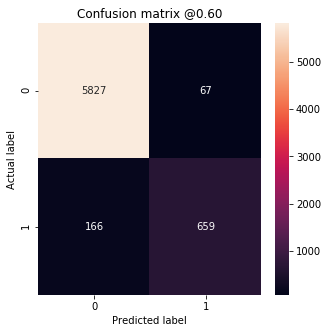

Not Planets Properly Categorized (True Negatives):  5827
Not Planets Categorized as Planets Detected (False Positives):  67
Planets Missed (False Negatives):  166
Planets Properly Categorized (True Positives):  659
Total Planets:  825
Accuracy:  0.965322220568537


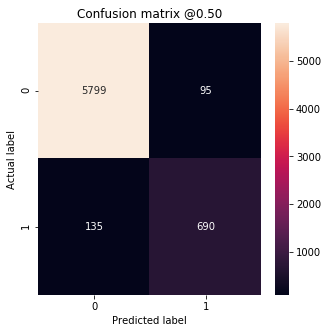

Not Planets Properly Categorized (True Negatives):  5799
Not Planets Categorized as Planets Detected (False Positives):  95
Planets Missed (False Negatives):  135
Planets Properly Categorized (True Positives):  690
Total Planets:  825
Accuracy:  0.965768715582676


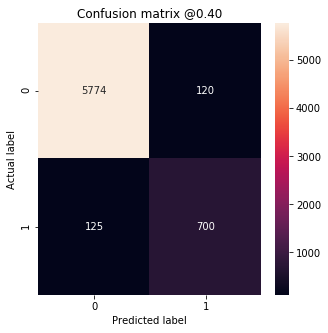

Not Planets Properly Categorized (True Negatives):  5774
Not Planets Categorized as Planets Detected (False Positives):  120
Planets Missed (False Negatives):  125
Planets Properly Categorized (True Positives):  700
Total Planets:  825
Accuracy:  0.963536240511981


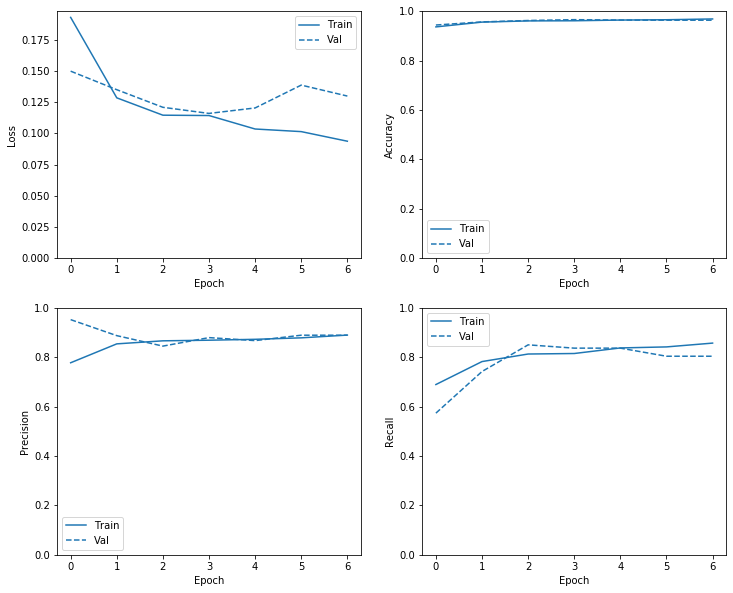

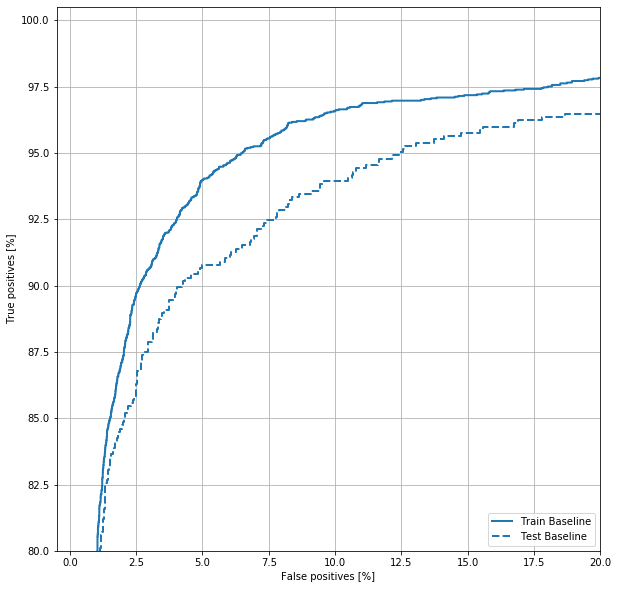

In [52]:
plot_cm(Y_val, val_predictions_baseline,p=.6)
plot_cm(Y_val, val_predictions_baseline)
plot_cm(Y_val, val_predictions_baseline,p=.4)
plot_metrics(history)

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### Model utility functions

In [ ]:
#graphical evaluation of model

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_metrics(history)

plot_cm(Y_val, val_predictions_baseline,p=.6)
plot_cm(Y_val, val_predictions_baseline)
plot_cm(Y_val, val_predictions_baseline,p=.4)


plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
#save model
model.save(os.path.join(MODEL_DIR,'normal_model'))

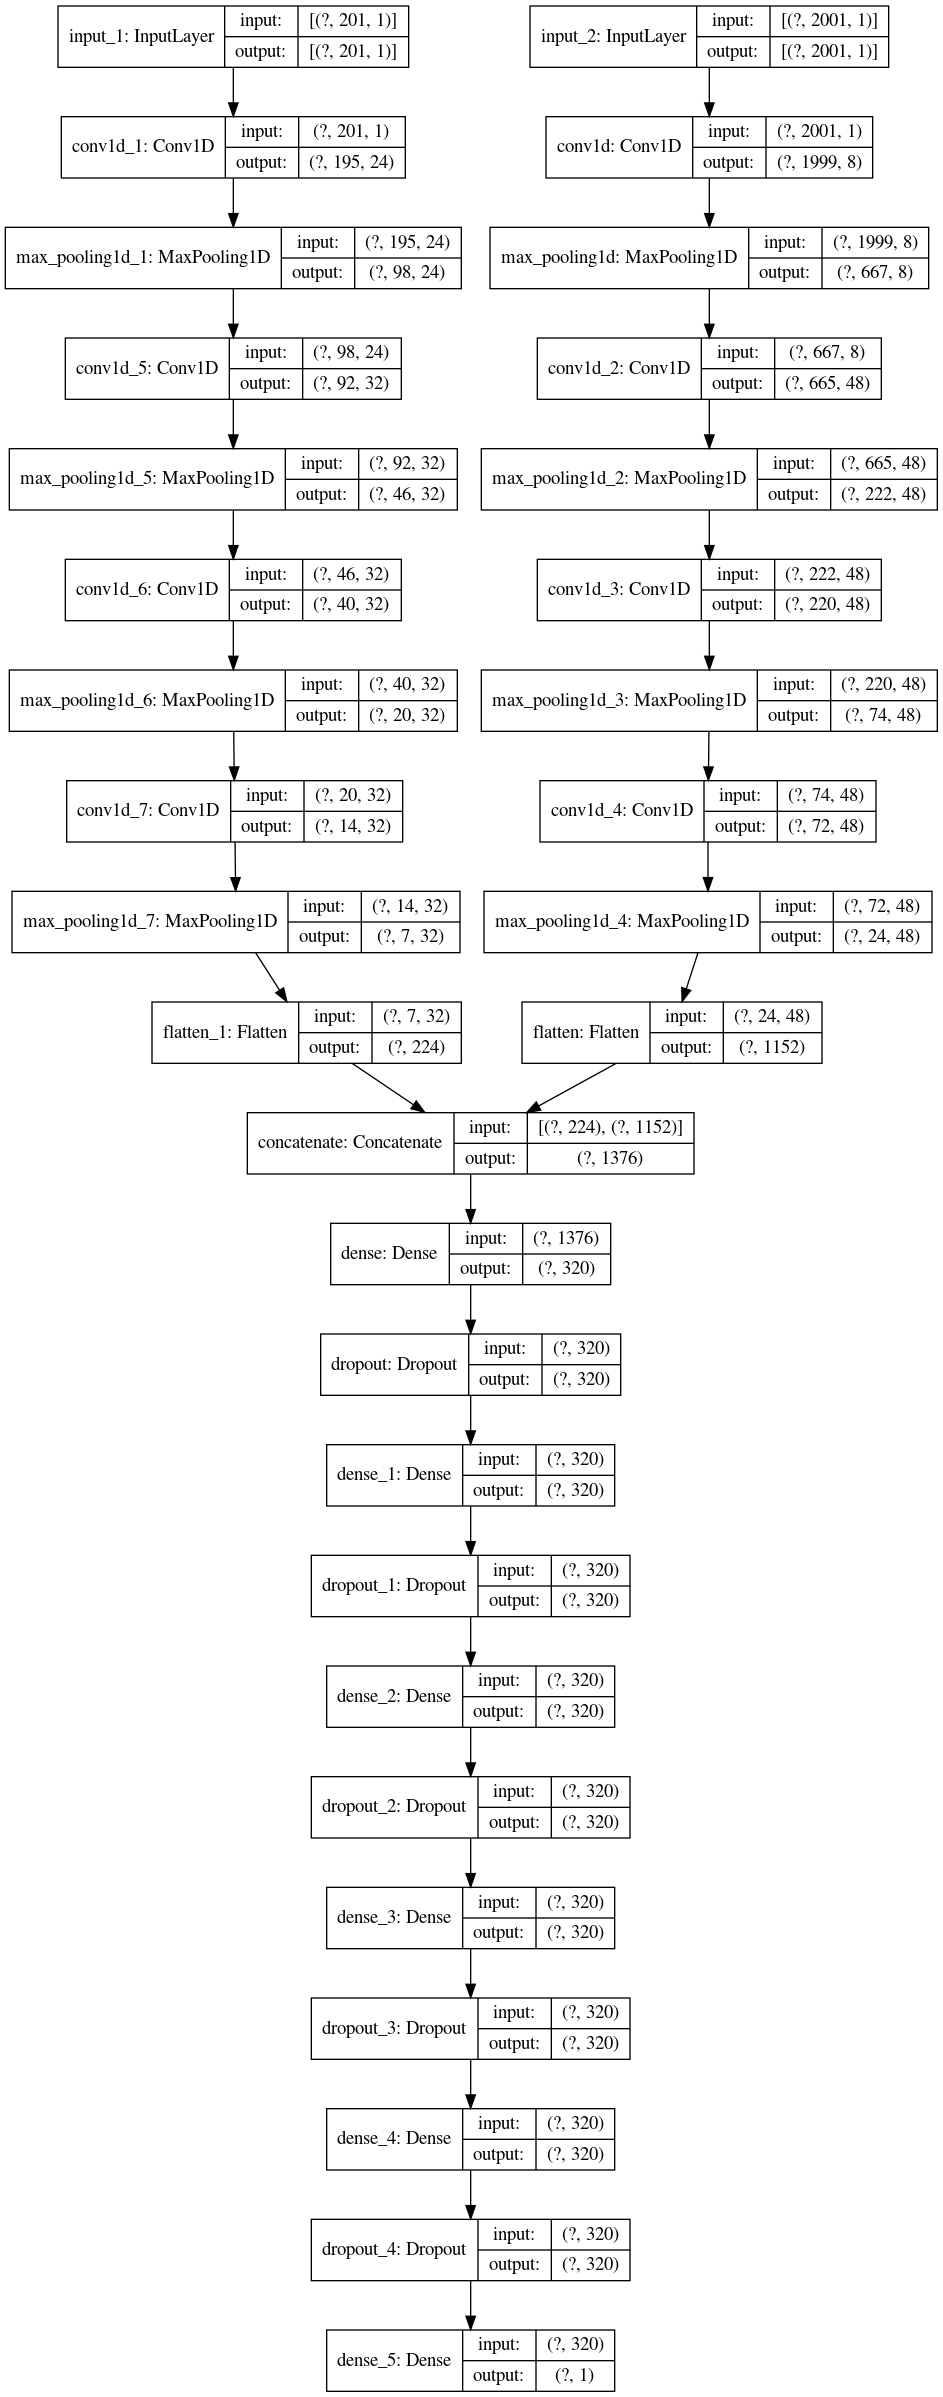

In [25]:
#picture of model
tf.keras.utils.plot_model(
    model, to_file=os.path.join(MODEL_DIR,'model.png'), show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

In [ ]:
#load model
model = tf.keras.models.load_model(os.path.join(MODEL_DIR,'normal_model'))
model.summary()

#### Create Disposition Prediction for Entire Dataset and Save CSV

In [ ]:
full_predictions = model.predict([x_local,x_global])
#full_predictions

print(full_predictions.shape)
print(Y.shape)
plot_cm(Y, full_predictions)

processed_final=processed.copy()
processed_final['w2p_score']=full_predictions
processed_final['w2p_disposition']='FALSE POSITIVE'
processed_final.loc[processed_final.w2p_score>=0.5,['w2p_disposition']]='CONFIRMED'
processed_final.replace({'koi_disposition':
                   {'1-CONFIRMED':'CONFIRMED','0-FALSE POSITIVE':'FALSE POSITIVE'}},
                  inplace=True)

#key columns to compare
#koi_disposition
#https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html
#https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html (has AV descriptions)
#koi_pdisposition and koi_score are ROBOVETTER outcomes (where available)
print('w2p_disposition:',processed_final.w2p_disposition.value_counts())
print('koi disposition:',processed_final.koi_disposition.value_counts())
print('koi pdisposition:',processed_final.koi_pdisposition.value_counts())
print('koi pdisposition:',processed_final.koi_pdisposition.value_counts())

#av_pp_pc is posterior probability score from autovetter model (where available).  
#Have divided by 100 to make comparable to koi_score
#and created a column representing AV disposition / unclear how differs from av_pred_class
processed_final.av_vf_pc=processed_final.av_vf_pc/100
processed_final['av_disposition']='FALSE POSITIVE'
processed_final.loc[processed_final.av_vf_pc>.5,['av_disposition']]='CONFIRMED'
print('AV disposition:',processed_final.av_disposition.value_counts())

#replacing koi_score with zero where NAN.  Only 8000 of TCEs had koi_score and koi_pdisposition (ie robovetter)
#same with av_vf_pc
processed_final.koi_score.fillna(0,inplace=True)
processed_final.av_vf_pc.fillna(0,inplace=True)

#koi_score is RV monte carlo prob.  koi_pdisposition is some subjective measure beyond RV score
processed_final[(processed_final.koi_score>=0.5)&(processed_final.koi_pdisposition=='FALSE POSITIVE')][[
    'kepid','tce_plnt_num','koi_disposition','koi_score','koi_pdisposition','w2p_score','w2p_disposition','av_disposition','av_vf_pc']]

print(processed_final[[
    'kepid','tce_plnt_num','koi_disposition',
    'w2p_score','w2p_disposition',
    'koi_score','koi_pdisposition',
    'av_disposition','av_vf_pc']])

processed_final.to_csv(os.path.join(PROCESSED_DATA_DIR,'processed_final.csv'),index=False)

#### Key column descriptions
- koi_disposition:  ground truth
- w2p_score: w2p probability
- w2p_disposition: w2p disposition
- koi_score: robovetter probability
- koi_pdisposition: robovetter disposition (though does not exactly match up with koi_score>0.5- unclear why)
- av_disposition: autovetter disposition (does not exactly match up with av_vf_pc>0- unclear why)
- av_vf_pc: autovetter probability (not posterior)

Links for other column descriptions:

https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html (has AV descriptions)

#### Error Analysis

In [ ]:
val_results=pd.DataFrame({'truth':Y_val, 'prediction':np.squeeze(val_predictions_baseline)})
val_results['truth_delta']=val_results.truth-val_results.prediction
val_results=val_results.sort_values('truth_delta')

val_results['result']='True Positive'
val_results.loc[val_results.truth_delta<0,'result']='True Negative' #then some get replaced by false positive
val_results.loc[val_results.truth_delta<=-0.5,'result']='False Positive'
val_results.loc[val_results.truth_delta>=0.5,'result']='False Negative'

print(val_results.result.value_counts())

cutoff=.05
val_results_mod=val_results[(val_results.truth_delta<-cutoff)|(val_results.truth_delta>cutoff)]
ax = sns.histplot(data=val_results_mod, 
                  x="truth_delta",
                  hue='result').set_title('Distribution of Deltas (excluding vast majority between -.05 and .05)')


val_results_mod=val_results[(val_results.prediction>cutoff)]
ax = sns.histplot(data=val_results_mod, 
                  x="prediction",
                  hue='result',
                  multiple='stack',
                  bins=30).set_title('Distribution of Validation Set Predictions (excluding true negatives <0.05)')

plt.axvline(0.5,0,30)

false_positives=val_results[val_results.truth_delta<=-.5]
print(false_positives.shape)
false_positives

tce_number=835
chart(tce_number,tce_id,val_results,x_global_val,x_local_val)

print(val_results.result[790])

false_negatives=val_results[val_results.truth_delta>=0.5].sort_values('truth_delta',ascending=False)
print (false_negatives.shape)
false_negatives

tce_number=629
chart_curves(9999,0,
             'FALSE NEGATIVE',
             x_global_val[tce_number],x_local_val[tce_number])

print(val_results[val_results.result=='True Positive'].sort_values('prediction',ascending=False))
tce_number=118
chart_curves(9999,0,
             'TRUE POSITIVE',
             x_global_val[tce_number],x_local_val[tce_number])

print(val_results[val_results.result=='True Negative'].sort_values('prediction',ascending=True))
tce_number=135
chart_curves(9999,0,
             'TRUE NEGATIVE',
             x_global_val[tce_number],x_local_val[tce_number])

In [ ]:
baseline_results = model.evaluate([x_local_train,x_global_train],Y_train,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

#### CVRandomSearch (but using Keras Hypertune above)

In [ ]:
cnn_global_filters_opts=[[16,32,64,128,256],[16,32],[32,64,128]]
cnn_global_kernel_opts=[5,2,3,7]
cnn_global_maxpool_window_opts=[3,5,7]
cnn_global_maxpool_stride_opts=[1,2,3]
cnn_local_filters_opts=[[16,32],[8,16,32],[8,16,32,64]]
cnn_local_kernel_opts=[5,2,3,7]
cnn_local_maxpool_window_opts=[5,7,9]
cnn_local_maxpool_stride_opts=[1,2,3]
fc_dropout_rate_opts  = [0, 0.2, 0.5]
fc_layers_opts = [[64, 64, 64, 64], [128, 128, 128], [512,512,512,512],[256,256,256]]
l2_penalty_opts = [0.01, 0.1, 0.5]
activation_opts=['relu','prelu']
optimizer_opts=['adam']
epochs_opts=[10,15,20]
batch_size_opts=[64,96,128]


keras_param_options = {
    'cnn_global_filters':cnn_global_filters_opts,
    'cnn_global_kernel':cnn_global_kernel_opts,
    'cnn_global_maxpool_window':cnn_global_maxpool_window_opts,
    'cnn_global_maxpool_stride':cnn_global_maxpool_stride_opts,
    'cnn_local_filters':cnn_local_filters_opts,
    'cnn_local_kernel':cnn_local_kernel_opts,
    'cnn_local_maxpool_window':cnn_local_maxpool_window_opts,
    'cnn_local_maxpool_stride':cnn_local_maxpool_stride_opts,
    'fc_layers': fc_layers_opts,
    'fc_dropout_rate':fc_dropout_rate_opts,
    'l2_penalty': l2_penalty_opts,
    'activation':activation_opts,
    'optimizer':optimizer_opts,
    'epochs':epochs_opts,
    'batch_size':batch_size_opts
}

def make_cnn_model(param)
    model = Sequential()   
    
    
    input_local = tf.keras.layers.Input(shape=[x_local.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global.shape[1],1])
    
    #combi_input = tf.keras.layers.Input((2,)) # (None, 3)
    #input_local = Lambda(lambda x: tf.expand_dims(x[:,0],-1))(combi_input) # (None, 1) 
    #input_global = Lambda(lambda x: tf.expand_dims(x[:,1],-1))(combi_input) # (None, 1)
    
    
    
    #build global branch
    for index, filters in enumerate(cnn_global_filters):       
        if not index:
            k_global=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_global_kernel,
                                            activation=activation)(input_global)
        else:
            k_global=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_global_kernel,
                                            activation=activation)(k_global)
        
        k_global=tf.keras.layers.MaxPooling1D(pool_size=cnn_global_window,
                                              strides=cnn_global_stride,padding='same')(k_global)
    
    #build local branch
    for index, filters in enumerate(cnn_local_filters):       
        if not index:
            k_local=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_local_kernel,
                                            activation=activation)(input_local)
        else:
            k_local=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_local_kernel,
                                            activation=activation)(k_local)
        
        k_local=tf.keras.layers.MaxPooling1D(pool_size=cnn_local_window,
                                              strides=cnn_local_stride,padding='same')(k_local)
    #flatten and concatenate
    k_global=tf.keras.layers.Flatten()(k_global)
    k_local=tf.keras.layers.Flatten()(k_local)
    k = tf.keras.layers.concatenate([k_local, k_global])
    
    #now add dense layers
    for fc_layer in fc_layers:
            k=tf.keras.layers.Dense(fc_layer,activation=activation)(k)
            k=tf.keras.layers.Dropout(fc_dropout_rate)(k)
    
    #output layer        
    output=tf.keras.layers.Dense(1,activation='sigmoid')(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=optimizer,
                  metrics=METRICS)
    return model

#randomizedsearchcv
#but will not take multiple inputs

model_keras = tf.keras.wrappers.scikit_learn.KerasClassifier(
    build_fn = make_cnn_model
    )

# specify other extra parameters pass to the .fit
# number of epochs is set to a large number, we'll
# let early stopping terminate the training process
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

callbacks = [early_stop]

keras_fit_params = {   
    'callbacks': callbacks,
    'epochs': 20,
    'batch_size': 96,
    'validation_data': ([x_local_val,x_global_val], Y_val),
    'verbose': 1
}

rs_keras = RandomizedSearchCV( 
    model_keras, 
    param_distributions = keras_param_options,
    fit_params = keras_fit_params,
    scoring = 'neg_log_loss',
    n_iter = 3, 
    cv = 3,
    n_jobs = -1,
    verbose = 1
)


combi_input = np.stack([x_local_train, x_global_train], axis=-1)
#see https://stackoverflow.com/questions/56824968/grid-search-for-keras-with-multiple-inputs/62512554#62512554
rs_keras.fit([x_local_train,x_global_train], Y_train)
rs_keras.fit(combi_input, Y_train)

#rs_keras.fit([x_local_train,x_global_train],
#                  Y_train,
#                  validation_data=([x_local_val,x_global_val],Y_val),
#                  batch_size=BATCH_SIZE,
#                  epochs=EPOCHS,
#                  callbacks=[early_stopping],
#                  verbose=1)

print('Best score obtained: {0}'.format(rs_keras.best_score_))
print('Parameters:')
for param, value in rs_keras.best_params_.items():
    print('\t{}: {}'.format(param, value))


#### Old model work
- setting initial bias
- train simple model

In [ ]:
#work on setting initial bias
tf.keras.backend.clear_session()
model=make_model()
model.predict([x_local_train[:10],x_global_train[:10]])
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))
neg, pos = np.bincount(Y)
total = neg + pos
print(neg,pos,total)
initial_bias=np.log([pos/neg])
print(initial_bias)
model = make_model(output_bias = initial_bias)
model.predict([x_local_train[:10],x_global_train[:10]])
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

initial_weights = os.path.join(MODEL_DIR,'initial_weights')
model.save_weights(initial_weights)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

tf.keras.backend.clear_session()
model=make_model()
model.load_weights(initial_weights)

#history=model.fit([x_local_train,x_global_train],
#                  Y_train,
#                  validation_data=([x_local_val,x_global_val],Y_val),
#                  steps_per_epoch=25,
#                  epochs=EPOCHS*20,
#                  callbacks=[early_stopping],
#                  verbose=1)

EPOCHS=20

history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  callbacks=[early_stopping],
                  verbose=1)



#### Class weighting to deal with unbalanced classes

In [ ]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
tf.keras.backend.clear_session()
model=make_model()
#model.load_weights(initial_weights)

history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  class_weight=class_weight,
                  callbacks=[early_stopping],
                  verbose=2)

In [ ]:
plot_metrics(history)
plot_cm(Y_val, val_predictions_baseline)

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### Oversampling to deal with unbalanced classes

In [ ]:
#oversampling
bool_train_labels = Y_train != 0
pos_features_local = x_local_train[bool_train_labels]
neg_features_local = x_local_train[~bool_train_labels]
pos_features_global = x_global_train[bool_train_labels]
neg_features_global = x_global_train[~bool_train_labels]

pos_labels = Y_train[bool_train_labels]
neg_labels = Y_train[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features_local))
choices = np.random.choice(ids, len(neg_features_local))

res_pos_features_local = pos_features_local[choices]
res_pos_features_global = pos_features_global[choices]
res_pos_labels = pos_labels[choices]

print(res_pos_features_local.shape,res_pos_features_global.shape)

In [ ]:
res_features_local=np.concatenate([res_pos_features_local,neg_features_local],axis=0)
res_features_global=np.concatenate([res_pos_features_global,neg_features_global],axis=0)
res_labels=np.concatenate([res_pos_labels,neg_labels],axis=0)
order=np.arange(len(res_labels))
np.random.shuffle(order)
res_features_local=res_features_local[order]
res_features_global=res_features_global[order]
res_labels=res_labels[order]
print(res_features_local.shape,res_features_global.shape,res_labels.shape)

In [ ]:
tf.keras.backend.clear_session()
model=make_model()
history = model.fit(
        [res_features_local,res_features_global],
        res_labels,
        validation_data=([x_local_val,x_global_val],Y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=2)


In [ ]:
plot_metrics(history)
plot_cm(Y_val, val_predictions_baseline)

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### S3 functions

In [ ]:
def upload_model(model_dir,bucket_name):
    #s3_client=boto3.client('s3')
    session = boto3.Session()
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    for subdir, dirs, files in os.walk(model_dir):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=full_path[len(model_dir)+1:], Body=data)

bucket_name='w251-final-project-model'
upload_model(model_dir,bucket_name)